# Reproducing the Oxidation State Assignment Model from Jablonka et al.

This notebook reproduces the key methodology and results from:
**"Using collective knowledge to assign oxidation states of metal cations in metal–organic frameworks"**
([DOI: 10.1038/s41557-021-00717-y](https://doi.org/10.1038/s41557-021-00717-y))

## Table of Contents
1. [Environment Setup](#env)
2. [Load Data](#load)
3. [Featurization](#feat)
4. [Model Training](#train)
5. [Evaluation](#eval)
6. [SHAP Analysis](#shap)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
import pickle
import shap

**Phase 1: Viweing the performance of the pretrained model**

In [2]:
# Load feature matrix and labels
X = np.load("features_all.npy", allow_pickle=True)
y = np.load("labels_all.npy", allow_pickle=True)

# Load structure names (CSD IDs, optional but useful for later)
names_path = r"E:\Projects\Oxidation_used_data\names_all.pkl"

with open(names_path, "rb") as f:
    names = pickle.load(f)
# Check shape
print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Example CSD IDs:", names[:5])

Features shape: (211723, 116)
Labels shape: (211723, 1)
Example CSD IDs: ['DEWQUS', 'RIPPEN', 'CIQHOC', 'WIMWIB', 'EMETUL']


In [3]:
# Load the scaler and scale features
scaler = joblib.load("scaler_0.joblib")
X_scaled = scaler.transform(X)

# Load pretrained voting classifier
model = joblib.load("votingclassifier.joblib")

In [4]:
print(X_scaled.shape)

(211723, 116)


In [5]:
# Predict only the first 1000 oxidation states
y_pred = model.predict(X_scaled[:1000])

# (Optional) Evaluate on first 1000 labels
from sklearn.metrics import classification_report

print(classification_report(y[:1000], y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       182
           2       1.00      1.00      1.00       596
           3       1.00      0.99      1.00       163
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        25

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



Accuracy: 0.997
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       182
           2       1.00      1.00      1.00       596
           3       1.00      0.99      1.00       163
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        25

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



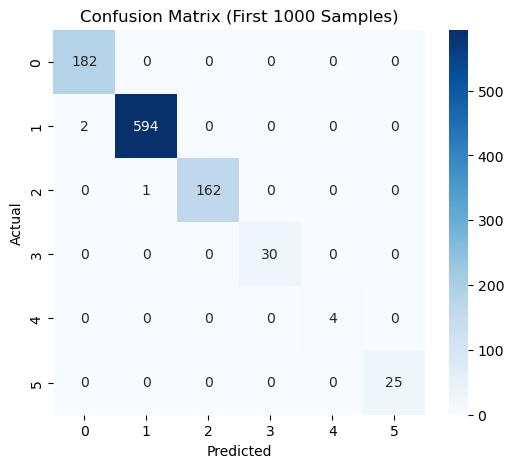

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# True vs predicted for the first 1000
y_true_1000 = y[:1000]
y_pred_1000 = model.predict(X_scaled[:1000])

# Accuracy
print("Accuracy:", accuracy_score(y_true_1000, y_pred_1000))

# Classification report
print(classification_report(y_true_1000, y_pred_1000))

# Confusion matrix
conf = confusion_matrix(y_true_1000, y_pred_1000)
plt.figure(figsize=(6, 5))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (First 1000 Samples)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Features relative importance of the pre-trained model**

In [7]:
df = pd.read_csv(r"E:\Projects\Oxidation_used_data\all_data.csv")
print(df.columns.tolist())

['Unnamed: 0', 'local difference in MendeleevNumber', 'local difference in Column', 'local difference in Row', 'local difference in Electronegativity', 'local difference in NsValence', 'local difference in NpValence', 'local difference in NdValence', 'local difference in NfValence', 'local difference in NValence', 'local difference in NsUnfilled', 'local difference in NpUnfilled', 'local difference in NdUnfilled', 'local difference in NfUnfilled', 'local difference in NUnfilled', 'local difference in GSbandgap', 'local signed difference in MendeleevNumber', 'local signed difference in Column', 'local signed difference in Row', 'local signed difference in Electronegativity', 'local signed difference in NsValence', 'local signed difference in NpValence', 'local signed difference in NdValence', 'local signed difference in NfValence', 'local signed difference in NValence', 'local signed difference in NsUnfilled', 'local signed difference in NpUnfilled', 'local signed difference in NdUnfill

In [8]:
X = np.load("features_all.npy")
print(X.shape)  # Should print (n, 116)

(211723, 116)


In [9]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt

# === Step 1: Load the full dataset ===
df = pd.read_csv(r"E:\Projects\Oxidation_used_data\all_data.csv")

# === Step 2: Separate labels ===
y_df = df["oxidationstate"]

# === Step 3: Drop non-numeric columns ===
X_df = df.drop(columns=["oxidationstate"])
X_df_numeric = X_df.select_dtypes(include=["number"])

# === Step 4: Align to expected feature size (116) ===
# The scaler was trained on exactly 116 features
X_df_aligned = X_df_numeric.iloc[:1000, :116]

# === Step 5: Load pretrained scaler and apply ===
scaler = joblib.load("scaler_0.joblib")
X_scaled_shap = scaler.transform(X_df_aligned)

# === Step 6: Load pretrained model ===
model_shap = joblib.load("votingclassifier.joblib")

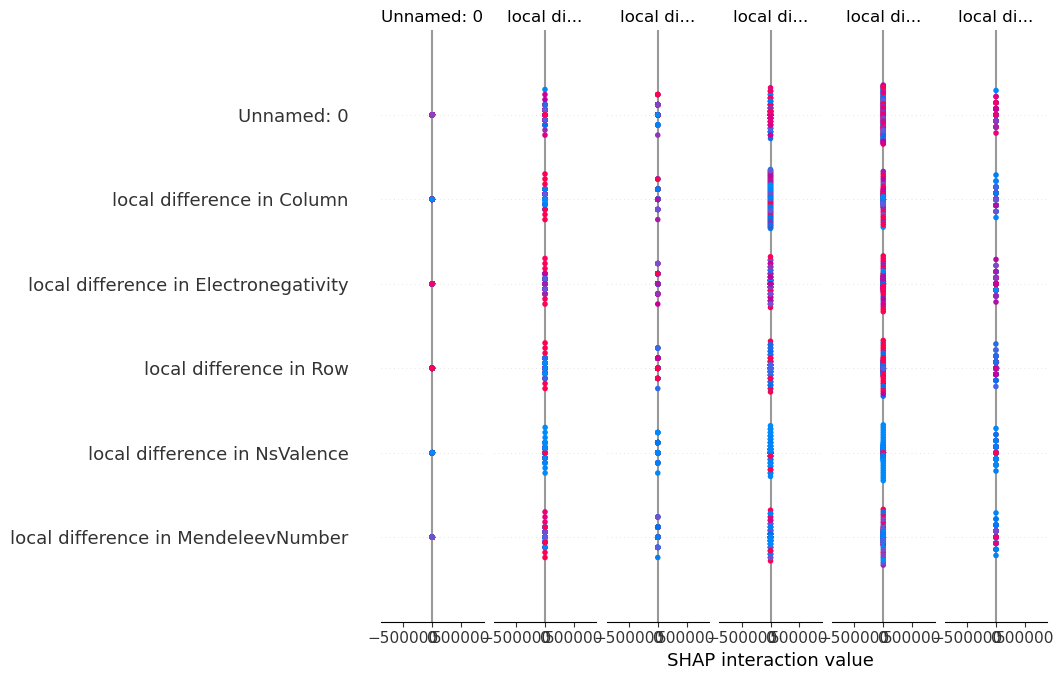

In [10]:
# === Step 7: Create SHAP explainer from one base model (e.g., Extra Trees) ===
base_model = model_shap.estimators[0].base_estimator    # Usually ExtraTreesClassifier
explainer = shap.Explainer(base_model, X_scaled_shap[:100])  # Use first 100 for SHAP

# === Step 8: Compute SHAP values ===
shap_values = explainer(X_scaled_shap[:100])

# === Step 9: Plot SHAP summary (global feature importance) ===
shap.summary_plot(shap_values, X_scaled_shap[:100], feature_names=X_df_aligned.columns)

**Phase 2: Regenerating the workflow to learn from the paper**

***Step 1: Viweing their parsed data***

In [11]:
# Load structure names (CSD IDs, optional but useful for later)
names_path = r"E:\Projects\Oxidation_used_data\names_all.pkl"

with open(names_path, "rb") as f:
    names = pickle.load(f)

print("Total environments loaded:", len(names))
print("Example records:")
for i in range(-5, 0):
    print(f"CSD ID: {names[i]}, Label: {y[i]}")

Total environments loaded: 211723
Example records:
CSD ID: LOPFEB, Label: [1]
CSD ID: DIYDIZ, Label: [3]
CSD ID: UGEBAJ, Label: [2]
CSD ID: EQITON, Label: [2]
CSD ID: TEZDOU, Label: [3]


In [12]:
import pickle

names_path = r"E:\Projects\Oxidation_used_data\names_all.pkl"
with open(names_path, "rb") as f:
    names = pickle.load(f)

print("Type of object:", type(names))
print("Length:", len(names))
print("First 10 entries:", names[:10])

Type of object: <class 'list'>
Length: 211723
First 10 entries: ['DEWQUS', 'RIPPEN', 'CIQHOC', 'WIMWIB', 'EMETUL', 'FAMMOW', 'FENKUF', 'XOKVUP', 'JIRLII', 'PEBFEI']


***Excluded Datasets***

In [13]:
import pickle

clash_path = r"E:\Projects\materials-ml-projects-\Projects\P_5_Oxidation_State_Assignment\learn_mof_ox_state\data\clashing_atoms.pkl"   # 'r' denotes read mode (raw string)
with open(clash_path, "rb") as f:                                                                                                       # 'rb' denotes read-binary mode
    clashing_ids = pickle.load(f)

print("Number of structures with atomic overlaps:", len(clashing_ids))
print("First 10 excluded CSD IDs:", clashing_ids[:10])

Number of structures with atomic overlaps: 6926
First 10 excluded CSD IDs: ['ABEHOH', 'ABEXAI', 'ABULEP', 'ABZCUH04', 'ACABEM', 'AGOTAS', 'AGOPIV', 'AGEWOB', 'AGOPAN', 'AGOJEN']


***Step 2: Demonstrating the expected difference between scaler_0 vs StandardScaler***

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# Load the scaler and transform
scaler_loaded = joblib.load("scaler_0.joblib")
X_scaled_loaded = scaler_loaded.transform(X)

# Fit a new scaler on the same X and transform
scaler_manual = StandardScaler().fit(X)
X_scaled_manual = scaler_manual.transform(X)

# Check if the transformed arrays are the same
print("Transformed X equal?", np.allclose(X_scaled_loaded, X_scaled_manual))
print("Means same?", np.allclose(scaler_loaded.mean_, scaler_manual.mean_))
print("Scales same?", np.allclose(scaler_loaded.scale_, scaler_manual.scale_))

# Optionally, print any difference if they are not the same
if not np.allclose(X_scaled_loaded, X_scaled_manual):
    print("Max absolute difference:", np.max(np.abs(X_scaled_loaded - X_scaled_manual)))


Transformed X equal? False
Means same? False
Scales same? False
Max absolute difference: 77655.73938969693


**Figuring out the featurization strategy**   
A short summary of the paper's featurize.py file.

In [15]:
METAL_CENTER_FEATURES = [
    "column", "row", "valenceelectrons", "diffto18electrons", "sunfilled", "punfilled", "dunfilled"
]
GEOMETRY_FEATURES = ["crystal_nn_fingerprint", "behler_parinello"]
CHEMISTRY_FEATURES = ["local_property_stats"]

DEFAULT_FEATURE_SET = (
    ["local_property_stats"]  # neighbor chemistry
    + ["column", "row", "valenceelectrons", "diffto18electrons", "sunfilled", "punfilled", "dunfilled"]  # metal identity
    + ["crystal_nn_no_steinhardt"]  # geometry (order parameters)
)

**Step 3: replicating the key methodologies and results of the paper With newly scrapped  dataset.**  
The paper claims:
'the model that was trained only on MOFs can be transferred to
other types of material, such as binary ionic solids or simple metal
complexes.' Hence, I choose to go with binary ionic solids.

In [2]:
import sys
print(sys.executable)


c:\Users\sayee\miniconda3\envs\oxistate\python.exe


**a. Fetching the data**

In [2]:
import sys
sys.path.append(r"E:\Projects\oximachine_featurizer") 
from pymatgen.ext.matproj import MPRester
from pymatgen.core.periodic_table import Element
from pymatgen.core import Structure
import numpy as np
from oximachine_featurizer import featurize

API_KEY = "gJvlWQFS6oWgMkCzghhy8YMSAYjtEv1B"

all_metals = [el.symbol for el in Element if el.is_metal]
anions = ["O", "S", "Se", "F", "Cl", "Br", "I", "N", "P"]

a.1: Materials project:  

In [4]:
# X, y, mp_ids, metals = [], [], [], []

# with MPRester(API_KEY) as mpr:
#     for metal in all_metals:
#         for anion in anions:
#             if metal == anion:
#                 continue
#             docs = mpr.summary.search(
#                 elements=[metal, anion],
#                 fields=["material_id", "formula_pretty", "cif", "elements"]
#             )
#             for d in docs:
#                 try:
#                     struct = Structure.from_str(d.cif, fmt="cif")
#                     struct.add_oxidation_state_by_guess()
#                     features, metal_indices, metal_symbols = featurize(struct)
#                     for j, idx in enumerate(metal_indices):
#                         el = struct[idx].specie
#                         ox = el.oxi_state if hasattr(el, "oxi_state") else None
#                         if ox is not None:
#                             X.append(features[j])
#                             y.append(ox)
#                             mp_ids.append(d.material_id)
#                             metals.append(str(el))
#                 except Exception as e:
#                     print(f"{d.material_id}: {e}")

# X = np.array(X)
# y = np.array(y)
# print("Feature matrix shape:", X.shape)
# print("Labels shape:", y.shape)
# print("Example labels:", y[:10])

a.2: OQMD:   
they have partial ICSD tagged data which can be adapted to the paper more easily.

In [3]:
import requests
import pandas as pd

base_url = "http://oqmd.org/oqmdapi/formationenergy"
fields = "name,entry_id,icsd_id,sites,unit_cell,composition_generic"
batch_size = 100
offset = 0
max_entries = 7000
all_entries = []

while len(all_entries) < max_entries:
    url = (
        f"{base_url}?fields={fields}"
        f"&format=json"
        f"&limit={batch_size}"
        f"&offset={offset}"
    )
    resp = requests.get(url)
    if resp.status_code != 200:
        print("Error:", resp.text[:300])
        break
    data = resp.json()
    if not data or not data.get("data"):
        break
    # Only collect up to max_entries
    for row in data["data"]:
        if row.get("icsd_id") and str(row["icsd_id"]).strip() != "0":
            all_entries.append(row)
            if len(all_entries) >= max_entries:
                break
    print(f"Collected {len(all_entries)}/{max_entries} entries so far...")  # progress printout
    if len(data["data"]) < batch_size or len(all_entries) >= max_entries:
        break
    offset += batch_size

df = pd.DataFrame(all_entries[:max_entries])
df.to_csv("oqmd_icsd_unitcell_composition_name.csv", index=False)
print(f"Saved {len(df)} ICSD-tagged entries with unit cell and composition.")

Collected 98/7000 entries so far...
Collected 198/7000 entries so far...
Collected 298/7000 entries so far...
Collected 398/7000 entries so far...
Collected 498/7000 entries so far...
Collected 598/7000 entries so far...
Collected 698/7000 entries so far...
Collected 798/7000 entries so far...
Collected 898/7000 entries so far...
Collected 998/7000 entries so far...
Collected 1098/7000 entries so far...
Collected 1198/7000 entries so far...
Collected 1298/7000 entries so far...
Collected 1398/7000 entries so far...
Collected 1498/7000 entries so far...
Collected 1598/7000 entries so far...
Collected 1698/7000 entries so far...
Collected 1798/7000 entries so far...
Collected 1898/7000 entries so far...
Collected 1998/7000 entries so far...
Collected 2098/7000 entries so far...
Collected 2198/7000 entries so far...
Collected 2298/7000 entries so far...
Collected 2398/7000 entries so far...
Collected 2498/7000 entries so far...
Collected 2598/7000 entries so far...
Collected 2698/7000 ent

**Finding the Metal/(s) in the compound**

In [2]:
import pandas as pd
from pymatgen.core.periodic_table import Element
from pymatgen.core import Composition

df = pd.read_csv("oqmd_icsd_unitcell_composition_name.csv")

def find_metals(formula):
    try:
        comp = Composition(formula)
        # List all elements in the composition that are metals
        return [el.symbol for el in comp.elements if Element(el.symbol).is_metal]
    except Exception:
        return []

df['metals'] = df['name'].apply(find_metals)
df = df[df['metals'].map(len) > 0]  # Filter to only those with at least one metal
df.to_csv("oqmd_icsd_with_metals.csv", index=False)
print("Done. File with 'metals' column saved.")
df.shape

Done. File with 'metals' column saved.


(6803, 7)

**Filter for multi-element compositions:**

In [3]:
import pandas as pd

df = pd.read_csv("oqmd_icsd_with_metals.csv")
# e.g., keep if generic composition has more than one unique symbol
df = df[df['composition_generic'].str.len() > 1]
df.to_csv("oqmd_icsd_with_compounds_only.csv", index=False)
df.shape

(6693, 7)

**Assigning Labels manually**  
Only compounds are considered.

In [22]:
import pandas as pd
from pymatgen.core import Composition, Element
from itertools import product

# Example fallback ox states (expand as needed)
common_ox = {
    "Fe": [2, 3], "Cu": [1, 2], "Cr": [2, 3, 6], "Mn": [2, 3, 4, 7], "Co": [2, 3], "Ni": [2, 3],
    "V": [3, 4, 5], "Ti": [3, 4], "Mo": [4, 6], "Ag": [1, 2], "Sn": [2, 4], "Pb": [2, 4], "Au": [1, 3],
    "Al": [3], "Mg": [2], "Na": [1], "K": [1], "Ca": [2], "Zn": [2],
    # ...expand for your dataset
}

def assign_oxstate_multimetal(row):
    formula = row['name']
    metals = eval(row['metals']) if isinstance(row['metals'], str) else row['metals']
    try:
        comp = Composition(formula)
        # 1. Try pymatgen's logic first
        guesses = comp.oxi_state_guesses()
        if guesses:
            guess = guesses[0]
            ox_assign = {m: guess[m] for m in metals if m in guess}
            if ox_assign: return ox_assign

        # 2. Multi-metal fallback: try all combinations of possible oxidation states
        el_amt = {el.symbol: comp[el] for el in comp.elements}
        nonmetals = [el for el in el_amt if el not in metals]
        # (Optionally) guess anion charge as 0 for unknowns or use standard table if you want more accuracy

        # Generate all metal state combinations
        ox_ranges = [common_ox.get(m, [None]) for m in metals]
        for ox_tuple in product(*ox_ranges):
            total_charge = sum(el_amt[m]*ox for m, ox in zip(metals, ox_tuple))
            # Assume nonmetal/anion charge = 0; for better accuracy, you can guess e.g. O=-2
            if total_charge == 0:
                # Return a dict: {metal: ox for each metal}
                return {m: ox for m, ox in zip(metals, ox_tuple)}
        # 3. If still not possible, assign first possible for each metal (fallback)
        return {m: common_ox.get(m, [None])[0] for m in metals}
    except Exception:
        return {m: common_ox.get(m, [None])[0] for m in metals}

df = pd.read_csv("oqmd_icsd_with_compounds_only.csv")
df['oxstate_label'] = df.apply(assign_oxstate_multimetal, axis=1)
df.to_csv("oqmd_icsd_with_oxstate_labels.csv", index=False)
print("Saved: oqmd_icsd_with_oxstate_labels.csv")
print(df.shape)


Saved: oqmd_icsd_with_oxstate_labels.csv
(6693, 8)


**Data cleaning:**  
Removing the samples having a NaN in theirs labels which was manually assigned.

In [2]:
import pandas as pd

df = pd.read_csv("oqmd_icsd_with_oxstate_labels.csv")

def has_none_oxstate(row):
    oxdict = eval(row['oxstate_label']) if isinstance(row['oxstate_label'], str) else row['oxstate_label']
    return any(v is None for v in oxdict.values())

# Filter out rows with None in any metal oxidation state
filtered_df = df[~df.apply(has_none_oxstate, axis=1)]

print("Filtered shape:", filtered_df.shape)
filtered_df.to_csv("oqmd_icsd_with_oxstate_labels_no_none.csv", index=False)
filtered_df.head

Filtered shape: (3689, 8)


<bound method NDFrame.head of          name  entry_id  icsd_id composition_generic  \
0        YbSe      6321    33675                  AB   
2        ZnNi     17859   105469                  AB   
3        TiAg     10676    58369                  AB   
4        ZnNi     17860   105470                  AB   
5        YbTe      6320    33674                  AB   
...       ...       ...      ...                 ...   
6688    LaCl3      6033    31574                 AB3   
6689   GaAgS2     16030    92052                ABC2   
6690     Ag2S     16747    98452                 AB2   
6691  InCuSe2     23634   250247                ABC2   
6692   CsRuF6      5582    28694                ABC6   

                                              unit_cell  \
0     [[2.949803, -2.949803, 0.0], [-2.949803, 0.0, ...   
2     [[2.735285, 0.0, 0.0], [0.0, 2.735285, 0.0], [...   
3     [[2.858117, 0.0, 0.0], [0.0, 2.858117, 0.0], [...   
4     [[2.885519, 0.0, 0.0], [0.0, 2.885519, 0.0], [...   
5 

In [26]:
row = df.iloc[0]
print(row['oxstate_label'])
print(type(row['oxstate_label']))


{'Yb': 2.0}
<class 'str'>


In [34]:
# from pymatgen.analysis.local_env import LocalStructOrderParams

# print(LocalStructOrderParams.__init__.__doc__)


**Featurization**

*a. Using Matminer's* CrystalNNFingerprint*  
This was used for the replication purpose of the original paper.

In [ ]:
# # Cell 1: Imports and Setup
# import pandas as pd
# import numpy as np
# import ast
# from pymatgen.core import Lattice, Structure, Element
# from pymatgen.core.periodic_table import Element as PMGElement
# from pymatgen.analysis.local_env import VoronoiNN
# from matminer.featurizers.site import CrystalNNFingerprint

# # Cell 2: Metal center features (from the paper)
# def metal_center_features(el):
#     config = el.full_electronic_structure
#     valence_e = config[-1][2] if config else np.nan
#     filled_shell_distance = 18 - valence_e if valence_e is not None else np.nan
#     Z = el.Z
#     group = el.group
#     row = el.row
#     n_s = sum(1 for o in config if o[1] == 's')
#     n_p = sum(1 for o in config if o[1] == 'p')
#     n_d = sum(1 for o in config if o[1] == 'd')
#     unfilled_s = 2 - n_s
#     unfilled_p = 6 - n_p
#     unfilled_d = 10 - n_d
#     return [group, row, Z, valence_e, filled_shell_distance, unfilled_s, unfilled_p, unfilled_d]

# # Cell 3: Geometry (CrystalNNFingerprint)
# geom_featurizer = CrystalNNFingerprint.from_preset("ops")  # "ops" for order parameters

# def geometry_features(struct, idx):
#     # Returns the CrystalNNFingerprint ("ops") for the site
#     return geom_featurizer.featurize(struct, idx)

# # Cell 4: Local chemistry features—manual, as in the paper
# from matminer.utils.data import MagpieData
# magpie = MagpieData()

# def local_chemistry_features(struct, idx):
#     vnn = VoronoiNN()
#     neighs = vnn.get_nn_info(struct, idx)
#     center_site = struct[idx]
#     elems = [n['site'].specie for n in neighs]
#     weights = [n['weight'] for n in neighs]
#     chem_properties = [
#         'MendeleevNumber',
#         'Row',
#         'Group',
#         'Electronegativity',
#         'NValence',
#         'GSbandgap'
#         ]

#     features = []
#     for magpie_name in chem_properties:
#         try:
#             my_prop = magpie.get_elemental_property(center_site.specie, magpie_name)
#         except Exception:  
#            my_prop = np.nan
#         try:
#             n_props = magpie.get_elemental_properties(elems, magpie_name)
#         except Exception:
#             n_props = [np.nan] * len(elems)  # If error, fill with NaN
            
#         arr = np.array([x if x is not None else np.nan for x in (np.array(n_props) - my_prop)])
#         absarr = np.abs(arr)
#         wts = np.array(weights)
#         # Signed diff stats
#         if len(arr) == 0 or np.all(np.isnan(arr)):
#             features.extend([np.nan]*4)
#         else:
#             features.append(np.average(arr, weights=wts) if not np.all(np.isnan(arr)) else np.nan)
#             features.append(np.nanmin(arr))
#             features.append(np.nanmax(arr))
#             features.append(np.nanstd(arr))
#         # Abs diff stats
#         if len(absarr) == 0 or np.all(np.isnan(absarr)):
#             features.extend([np.nan]*4)
#         else:
#             features.append(np.average(absarr, weights=wts) if not np.all(np.isnan(absarr)) else np.nan)
#             features.append(np.nanmin(absarr))
#             features.append(np.nanmax(absarr))
#             features.append(np.nanstd(absarr))
#     return features


# # Cell 5: Featurize (one per unique metal per structure)
# df = pd.read_csv("oqmd_icsd_with_oxstate_labels_no_none.csv")

# all_features = []
# all_labels = []
# all_compound_ids = []
# all_metal_symbols = []

# for i, row in df.iterrows():
#     try:
#         cell = np.array(ast.literal_eval(row['unit_cell']))
#         sites = ast.literal_eval(row['sites'])
#         if isinstance(sites[0], str):
#             species = [s.split('@')[0].strip() for s in sites]
#             coords = [list(map(float, s.split('@')[1].strip().split())) for s in sites]
#         else:
#             species = [site['element'] for site in sites]
#             coords = [site['xyz'] for site in sites]
#         struct = Structure(Lattice(cell), species, coords, coords_are_cartesian=True)
#         metals = ast.literal_eval(row['metals']) if isinstance(row['metals'], str) else row['metals']
#         oxstate = ast.literal_eval(row['oxstate_label']) if isinstance(row['oxstate_label'], str) else row['oxstate_label']
#         for m in metals:
#             if m in oxstate:
#                 for idx, site in enumerate(struct):
#                     if Element(str(site.specie)).symbol == m:
#                         feat = []
#                         feat += metal_center_features(Element(m))
#                         feat += geometry_features(struct, idx)
#                         feat += local_chemistry_features(struct, idx)
#                         all_features.append(feat)
#                         all_labels.append(oxstate[m])
#                         all_compound_ids.append(row['entry_id'])
#                         all_metal_symbols.append(m)
#                         break
#     except Exception as e:
#         print(f"Error at row {i}: {e}")
#         continue

# np.save("feature_matrix_f.npy", np.array(all_features))
# np.save("labels_f.npy", np.array(all_labels))
# print(f"Saved {len(all_features)} samples, one per unique metal per structure.")

# # (Optional) Save mapping index for interpretation
# pd.DataFrame({
#     "entry_id": all_compound_ids,
#     "metal": all_metal_symbols,
#     "label": all_labels
# }).to_csv("feature_label_index.csv", index=False)

Saved 5692 samples, one per unique metal per structure.


In [ ]:
import matminer
print(matminer.__version__)

0.0.0


In [34]:
# from matminer.featurizers.site import GaussianSymmFunc

# gsf = GaussianSymmFunc(
#     etas_g2=[0.05, 4.0, 20.0, 80.0],
#     etas_g4=[0.005, 0.005, 0.005, 0.005],
#     zetas_g4=[1.0, 1.0, 4.0, 4.0],
#     gammas_g4=[-1.0, 1.0, -1.0, 1.0],
#     cutoff=6.5
# )

# # Print all feature labels (names) with their indices
# labels = gsf.feature_labels()
# for i, name in enumerate(labels):
#     print(f"{i}: {name}")


*b. With Papers Gaussian distributions*

In [ ]:
import numpy as np
import pandas as pd
from pymatgen.core import Lattice, Structure, Element
from pymatgen.analysis.local_env import VoronoiNN
from matminer.featurizers.site import CrystalNNFingerprint, GaussianSymmFunc
from matminer.utils.data import MagpieData
import ast

# --- LOAD YOUR DATA ---
df = pd.read_csv("oqmd_icsd_with_oxstate_labels_no_none.csv")
print("Loaded DataFrame shape:", df.shape)

magpie = MagpieData()
geom_featurizer = CrystalNNFingerprint.from_preset("ops")
gsf = GaussianSymmFunc(
    etas_g2=[0.05, 4.0, 20.0, 80.0],
    etas_g4=[0.005, 0.005, 0.005, 0.005],
    zetas_g4=[1.0, 1.0, 4.0, 4.0],
    gammas_g4=[-1.0, 1.0, -1.0, 1.0],
    cutoff=6.5
)

def metal_center_features(el):
    config = el.full_electronic_structure
    Z = el.Z
    group = el.group
    row = el.row
    valence = config[-1][2] if config else np.nan
    diffto18 = 18 - valence if valence is not None else np.nan
    n_s = sum(1 for o in config if o[1] == 's')
    n_p = sum(1 for o in config if o[1] == 'p')
    n_d = sum(1 for o in config if o[1] == 'd')
    sunfilled = 2 - n_s
    punfilled = 6 - n_p
    dunfilled = 10 - n_d
    feats = [group, row, Z, valence, diffto18, sunfilled, punfilled, dunfilled]
    names = ['group', 'row', 'Z', 'valenceelectrons', 'diffto18electrons', 'sunfilled', 'punfilled', 'dunfilled']
    return feats, names

def geometry_features(struct, idx):
    feats = geom_featurizer.featurize(struct, idx)
    names = geom_featurizer.feature_labels()
    return feats, names

def get_local_shell_props(el):
    config = el.full_electronic_structure
    n_s = sum(1 for o in config if o[1] == 's')
    n_p = sum(1 for o in config if o[1] == 'p')
    n_d = sum(1 for o in config if o[1] == 'd')
    n_f = sum(1 for o in config if o[1] == 'f')
    props = {
        'NsValence': n_s,
        'NpValence': n_p,
        'NdValence': n_d,
        'NfValence': n_f,
        'NsUnfilled': 2 - n_s,
        'NpUnfilled': 6 - n_p,
        'NdUnfilled': 10 - n_d,
        'NfUnfilled': 14 - n_f,
        'NUnfilled': (2 - n_s) + (6 - n_p) + (10 - n_d) + (14 - n_f)
    }
    return props

def local_chemistry_features(struct, idx):
    vnn = VoronoiNN()
    neighs = vnn.get_nn_info(struct, idx)
    center_site = struct[idx]
    elems = [n['site'].specie for n in neighs]
    weights = [n['weight'] for n in neighs]
    chem_properties = [
        "MendeleevNumber", "Column", "Row", "Electronegativity", "NsValence",
        "NpValence", "NdValence", "NfValence", "NValence",
        "NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled", "NUnfilled", "GSbandgap"
    ]
    features, names = [], []
    for prop in chem_properties:
        try:
            if prop in ["MendeleevNumber", "Column", "Row", "Electronegativity", "NValence", "GSbandgap"]:
                if prop == "Column":
                    center_val = Element(str(center_site.specie)).group
                    n_props = [Element(str(e)).group for e in elems]
                else:
                    center_val = magpie.get_elemental_property(center_site.specie, prop)
                    n_props = magpie.get_elemental_properties(elems, prop)
            else:
                center_val = get_local_shell_props(center_site.specie)[prop]
                n_props = [get_local_shell_props(e)[prop] for e in elems]
        except Exception:
            center_val = np.nan
            n_props = [np.nan] * len(elems)
        arr = np.array([x - center_val for x in n_props])
        wts = np.array(weights)
        if len(arr) == 0 or np.all(np.isnan(arr)):
            vals = [np.nan]*4
        else:
            vals = [
                np.average(np.abs(arr), weights=wts) if not np.all(np.isnan(arr)) else np.nan,  # abs_mean
                np.nanmax(np.abs(arr)),
                np.nanmin(np.abs(arr)),
                np.average(arr, weights=wts) if not np.all(np.isnan(arr)) else np.nan          # signed_mean
            ]
        features.extend(vals)
        names += [
            f"local difference in {prop}",
            f"maximum local difference in {prop}",
            f"mimum local difference in {prop}",
            f"local signed difference in {prop}",
        ]
    return features, names

def gaussian_symm_features(struct, idx):
    all_feats = gsf.featurize(struct, idx)
    indices = [0, 1, 2, 3, 4, 5, 12, 13]
    labels = gsf.feature_labels()
    feats = [all_feats[i] for i in indices]
    names = [labels[i] for i in indices]
    return feats, names

# --- MAIN FEATURE LOOP ---
all_features = []
feature_names_generated = None

for i, row in df.iterrows():
    try:
        cell = np.array(ast.literal_eval(row['unit_cell']))
        sites = ast.literal_eval(row['sites'])
        if isinstance(sites[0], str):
            species = [s.split('@')[0].strip() for s in sites]
            coords = [list(map(float, s.split('@')[1].strip().split())) for s in sites]
        else:
            species = [site['element'] for site in sites]
            coords = [site['xyz'] for site in sites]
        struct = Structure(Lattice(cell), species, coords, coords_are_cartesian=True)
        metals = ast.literal_eval(row['metals']) if isinstance(row['metals'], str) else row['metals']
        oxstate = ast.literal_eval(row['oxstate_label']) if isinstance(row['oxstate_label'], str) else row['oxstate_label']
        # DEBUG PRINT:
        #print(f"ROW {i}: metals={metals} oxstate={oxstate} species={species}")
        for m in metals:
            if m in oxstate:
                for idx, site in enumerate(struct):
                    #print(f"    Checking site idx={idx} site={site.specie} vs m={m}")
                    if Element(str(site.specie)).symbol == m:
                        #print(f"    --> MATCH: site={site.specie} with metal={m}")
                        feat, names = [], []
                        f, n = metal_center_features(Element(m)); feat += f; names += n
                        f, n = geometry_features(struct, idx); feat += f; names += n
                        f, n = local_chemistry_features(struct, idx); feat += f; names += n
                        f, n = gaussian_symm_features(struct, idx); feat += f; names += n
                        all_features.append(feat)
                        if feature_names_generated is None:
                            print("[DEBUG] Metal center:", len(metal_center_features(Element(m))[0]))
                            print("[DEBUG] Geometry:", len(geometry_features(struct, idx)[0]))
                            print("[DEBUG] Chemistry:", len(local_chemistry_features(struct, idx)[0]))
                            print("[DEBUG] Gaussian:", len(gaussian_symm_features(struct, idx)[0]))
                            print("[DEBUG] TOTAL:", len(feat))
                            print("[DEBUG] Names:", len(names))
                            feature_names_generated = names
                        break
    except Exception as e:
        print(f"Error at row {i}: {e}")
        continue

all_features = np.array(all_features)
print("Final shape:", all_features.shape)
print("Feature names:", len(feature_names_generated))
assert all_features.shape[1] == len(feature_names_generated), "Mismatch between features and names!"

# Save
np.save("all_features_replicated.npy", all_features)
pd.DataFrame(all_features, columns=feature_names_generated).to_csv("all_features_replicated.csv", index=False)

*c. Using Pymatgen's LocalStructOrderParams*

In [ ]:
# # Cell 1: Imports and Setup
# import pandas as pd
# import numpy as np
# import ast
# from pymatgen.core import Lattice, Structure, Element
# from pymatgen.core.periodic_table import Element as PMGElement
# from pymatgen.analysis.local_env import VoronoiNN, LocalStructOrderParams

# # Cell 2: Metal center features (from the paper)
# def metal_center_features(el):
#     config = el.full_electronic_structure
#     valence_e = config[-1][2] if config else np.nan
#     filled_shell_distance = 18 - valence_e if valence_e is not None else np.nan
#     Z = el.Z
#     group = el.group
#     row = el.row
#     n_s = sum(1 for o in config if o[1] == 's')
#     n_p = sum(1 for o in config if o[1] == 'p')
#     n_d = sum(1 for o in config if o[1] == 'd')
#     unfilled_s = 2 - n_s
#     unfilled_p = 6 - n_p
#     unfilled_d = 10 - n_d
#     return [group, row, Z, valence_e, filled_shell_distance, unfilled_s, unfilled_p, unfilled_d]

# # Cell 3: Geometry (order parameter) features
# ALL_OP_TYPES = [
#     "cn", "tet", "oct", "bcc", "tri_plan", "sq_plan", "pent_plan", "tri_pyr",
#     "sq_pyr", "pent_pyr", "hex_pyr", "tri_bipyr", "sq_bipyr", "pent_bipyr", 
#     "hex_bipyr", "cuboct", "q2", "q4", "q6"
# ]
# # Filter for supported ones:
# supported_types = []
# for op_type in ALL_OP_TYPES:
#     try:
#         LocalStructOrderParams(types=[op_type])
#         supported_types.append(op_type)
#     except Exception:
#         pass

# def geometry_features(struct, idx):
#     op = LocalStructOrderParams(types=supported_types)
#     op_vals = op.get_order_parameters(struct, idx)
#     return [val if val is not None else 0.0 for val in op_vals]

# # Cell 4: Local chemistry features—**manual, as in the paper**
# # List of properties, taken from the paper/supplement: 
# # mendeleev_no, row, group, eneg (electronegativity), valence, bandgap
# def get_element_props(el):
#     # For a PMGElement
#     return {
#         'mendeleev': el.mendeleev_no,
#         'row': el.row,
#         'group': el.group,
#         'eneg': el.X if el.X is not None else np.nan,
#         'valence': el.full_electronic_structure[-1][2] if el.full_electronic_structure else np.nan,
#         'bandgap': getattr(el, "band_gap", np.nan)
#     }

# def local_chemistry_features(struct, idx):
#     center_el = PMGElement(str(struct[idx].specie))
#     center_props = get_element_props(center_el)
#     # Voronoi neighbors and weights (facet area)
#     vnn = VoronoiNN()
#     neighs = vnn.get_nn_info(struct, idx)
#     prop_diffs = {k: [] for k in center_props}
#     prop_absdiffs = {k: [] for k in center_props}
#     weights = []
#     for n in neighs:
#         nbr_el = PMGElement(str(n['site'].specie))
#         nbr_props = get_element_props(nbr_el)
#         weight = n['weight']  # area-based weight (facet area, as in the paper)
#         weights.append(weight)
#         for k in center_props:
#             diff = nbr_props[k] - center_props[k] if (nbr_props[k] is not None and center_props[k] is not None) else np.nan
#             absdiff = abs(diff) if diff is not np.nan else np.nan
#             prop_diffs[k].append(diff)
#             prop_absdiffs[k].append(absdiff)
#     # Weighted stats (mean, min, max, std) for each property
#     features = []
#     for k in center_props:
#         arr = np.array(prop_diffs[k])
#         absarr = np.array(prop_absdiffs[k])
#         wts = np.array(weights)
#         # Signed diff stats
#         if len(arr) == 0 or np.all(np.isnan(arr)):
#             features.extend([np.nan]*4)
#         else:
#             features.append(np.average(arr, weights=wts) if not np.all(np.isnan(arr)) else np.nan)
#             features.append(np.nanmin(arr))
#             features.append(np.nanmax(arr))
#             features.append(np.nanstd(arr))
#         # Abs diff stats
#         if len(absarr) == 0 or np.all(np.isnan(absarr)):
#             features.extend([np.nan]*4)
#         else:
#             features.append(np.average(absarr, weights=wts) if not np.all(np.isnan(absarr)) else np.nan)
#             features.append(np.nanmin(absarr))
#             features.append(np.nanmax(absarr))
#             features.append(np.nanstd(absarr))
#     return features

# # Cell 5: Featurize (one per unique metal per structure)
# df = pd.read_csv("oqmd_icsd_with_oxstate_labels_no_none.csv")

# all_features = []
# all_labels = []
# all_compound_ids = []
# all_metal_symbols = []

# for i, row in df.iterrows():
#     try:
#         cell = np.array(ast.literal_eval(row['unit_cell']))
#         sites = ast.literal_eval(row['sites'])
#         if isinstance(sites[0], str):
#             species = [s.split('@')[0].strip() for s in sites]
#             coords = [list(map(float, s.split('@')[1].strip().split())) for s in sites]
#         else:
#             species = [site['element'] for site in sites]
#             coords = [site['xyz'] for site in sites]
#         struct = Structure(Lattice(cell), species, coords, coords_are_cartesian=True)
#         metals = ast.literal_eval(row['metals']) if isinstance(row['metals'], str) else row['metals']
#         oxstate = ast.literal_eval(row['oxstate_label']) if isinstance(row['oxstate_label'], str) else row['oxstate_label']
#         for m in metals:
#             if m in oxstate:
#                 # Only the first occurrence
#                 for idx, site in enumerate(struct):
#                     if Element(str(site.specie)).symbol == m:
#                         feat = []
#                         feat += metal_center_features(Element(m))
#                         feat += geometry_features(struct, idx)
#                         feat += local_chemistry_features(struct, idx)
#                         all_features.append(feat)
#                         all_labels.append(oxstate[m])
#                         all_compound_ids.append(row['entry_id'])
#                         all_metal_symbols.append(m)
#                         break
#     except Exception as e:
#         print(f"Error at row {i}: {e}")
#         continue

# np.save("feature_matrix.npy", np.array(all_features))
# np.save("labels.npy", np.array(all_labels))
# print(f"Saved {len(all_features)} samples, one per unique metal per structure.")

# # (Optional) Save index for provenance
# pd.DataFrame({
#     "entry_id": all_compound_ids,
#     "metal": all_metal_symbols,
#     "label": all_labels
# }).to_csv("feature_label_index.csv", index=False)

Saved 5692 samples, one per unique metal per structure.


**Loading the features and labels**

In [2]:
import numpy as np

X = np.load("all_features_replicated.npy")
y = np.load("labels_f.npy")

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("\nFirst 3 feature vectors and their labels:\n")
for i in range(3):
    print(f"Features[{i}]:\n{X[i]}")
    print(f"Label[{i}]: {y[i]}\n")


Feature matrix shape: (5692, 137)
Labels shape: (5692,)

First 3 feature vectors and their labels:

Features[0]:
[ 3.00000000e+00  6.00000000e+00  7.00000000e+01  2.00000000e+00
  1.60000000e+01 -4.00000000e+00  2.00000000e+00  8.00000000e+00
  7.53300873e-01  7.53300873e-01  1.89422691e-01  6.56731123e-14
  6.80901283e-09  1.10040571e-05  2.20027727e-02  1.89422691e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.18133432e-02  1.27108005e-02
  8.66774368e-03  7.67972311e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.54630931e-02  1.22337224e-03  1.47905802e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.000000

***Analysis and comparision***  
Papers' feature matrix vs. my feature matrix. The aim is to resemble as close as possible.

*Investigating the unique columns*

In [4]:
import pandas as pd

their_csv_path = "E:/Projects/Some Datasets/Oxidation_state assignment database/all_data.csv"
their_df = pd.read_csv(their_csv_path)

# Show the first 10 values of the "Unnamed: 0" column
print("Sample values from 'Unnamed: 0':")
print(their_df["Unnamed: 0"].head(10).tolist())

# Print the first 10 unique values in "stype"
print("Sample 'stype' values from their data:")
print(their_df["stype"].unique()[:10])

# If it's not present, check if the unnamed column is the index
if "Unnamed: 0" not in their_df.columns and their_df.columns[0].startswith("Unnamed"):
    print("First 10 values of index column:")
    print(their_df.iloc[:, 0].head(10).tolist())


Sample values from 'Unnamed: 0':
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Sample 'stype' values from their data:
['MOF' 'CSD' 'COD']


*Matching to the unique features*

In [4]:
import pandas as pd
import ast

# Load your original file
orig_df = pd.read_csv("oqmd_icsd_with_oxstate_labels_no_none.csv")

# These lists will be expanded
expanded_names = []
expanded_oxidationstates = []
expanded_stypes = []

for i, row in orig_df.iterrows():
    # Metals column as list
    metals = ast.literal_eval(row['metals']) if isinstance(row['metals'], str) else row['metals']
    # Oxidationstates as dict
    oxstates = ast.literal_eval(row['oxstate_label']) if isinstance(row['oxstate_label'], str) else row['oxstate_label']
    # Repeat for every metal in that entry
    for m in metals:
        expanded_names.append(row['name'])
        expanded_oxidationstates.append(oxstates[m])
        expanded_stypes.append(m)  # species type = metal symbol

print("Number of expanded rows:", len(expanded_names))
print("Number of expanded oxidationstates:", len(expanded_oxidationstates))
print("Number of expanded stypes:", len(expanded_stypes))

Number of expanded rows: 5692
Number of expanded oxidationstates: 5692
Number of expanded stypes: 5692


*Feature matrix shape matched!!!*

In [5]:
import pandas as pd

# Load your existing features (the file with 5692 rows)
df_feat = pd.read_csv("all_features_replicated.csv")

# Rename 'group' to 'column' if present
if 'group' in df_feat.columns:
    df_feat.rename(columns={'group': 'column'}, inplace=True)

# Add columns
df_feat['name'] = expanded_names
df_feat['oxidationstate'] = expanded_oxidationstates
df_feat['stype'] = expanded_stypes

# Save
df_feat.to_csv("all_features_final.csv", index=False)
print("✅ Final file written with extra columns.")
print("Final DataFrame shape:", df_feat.shape)

# Show the first five values for name, column, oxidationstate, stype
print("\nFirst five rows [name, column, oxidationstate, stype]:")
print(df_feat[['name', 'column', 'oxidationstate', 'stype']].head(5))

✅ Final file written with extra columns.
Final DataFrame shape: (5692, 140)

First five rows [name, column, oxidationstate, stype]:
   name  column  oxidationstate stype
0  YbSe     3.0             2.0    Yb
1  ZnNi    12.0             2.0    Zn
2  ZnNi    10.0             2.0    Ni
3  TiAg     4.0             3.0    Ti
4  TiAg    11.0             1.0    Ag


In [6]:
# feature names (from the last featurization step)
my_names = pd.read_csv("all_features_final.csv", nrows=0).columns.tolist()

# Their feature names (from the paper's all_data.csv)
their_csv_path = "E:/Projects/Some Datasets/Oxidation_state assignment database/all_data.csv"  # update if needed
their_names = pd.read_csv(their_csv_path, nrows=0).columns.tolist()

# Show counts
print(f"Your features: {len(my_names)}")
print(f"Their features: {len(their_names)}")

# Show names side by side for manual auditing
maxlen = max(len(my_names), len(their_names))
print(f"\n{'Idx':<5} {'YOURS':<40} {'THEIRS'}")
for i in range(maxlen):
    myf = my_names[i] if i < len(my_names) else ""
    thf = their_names[i] if i < len(their_names) else ""
    print(f"{i:<5} {myf:<40} {thf}")

# Optionally, show intersection and differences
only_in_yours = set(my_names) - set(their_names)
only_in_theirs = set(their_names) - set(my_names)
print("\nFeatures ONLY in yours:", only_in_yours)
print("Features ONLY in theirs:", only_in_theirs)
print("Number of shared features:", len(set(my_names) & set(their_names)))

Your features: 140
Their features: 140

Idx   YOURS                                    THEIRS
0     column                                   Unnamed: 0
1     row                                      local difference in MendeleevNumber
2     Z                                        local difference in Column
3     valenceelectrons                         local difference in Row
4     diffto18electrons                        local difference in Electronegativity
5     sunfilled                                local difference in NsValence
6     punfilled                                local difference in NpValence
7     dunfilled                                local difference in NdValence
8     wt CN_1                                  local difference in NfValence
9     sgl_bd CN_1                              local difference in NValence
10    wt CN_2                                  local difference in NsUnfilled
11    L-shaped CN_2                            local difference in NpUnfi

**DATA Standardization and Cleaning for ML**  
The scaler was fitted to the training set only, transformed to both the train and test set.  Mixed valence compounds are not present in my parsed data. so it matches the papers strategy to teach the model the pattern as pure as possible.

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

# Load and filter
df = pd.read_csv("all_features_final.csv")
df = df[df["oxidationstate"].apply(float.is_integer)].copy()
df["oxidationstate"] = df["oxidationstate"].astype(int)
counts = df["oxidationstate"].value_counts()
valid_states = counts[counts >= 8].index
df = df[df["oxidationstate"].isin(valid_states)].copy()

# Save metadata as CSV
metadata_df = df.copy()
metadata_df.to_csv("cleaned_metadata_with_names.csv", index=False)
print("Metadata shape (rows, columns):", metadata_df.shape)

meta_counts = metadata_df["oxidationstate"].value_counts().sort_index()

# Prepare numeric features
X_full = df.drop(columns=["oxidationstate"]).select_dtypes(include=[float, int])
y_full = df["oxidationstate"]

# 1. Random (not stratified) holdout split (185 samples)
np.random.seed(42)
holdout_indices = np.random.choice(X_full.index, size=185, replace=False)
X_holdout = X_full.loc[holdout_indices].copy()
y_holdout = y_full.loc[holdout_indices].copy()

X_remain = X_full.drop(index=holdout_indices)
y_remain = y_full.drop(index=holdout_indices)

# 2. Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_remain, y_remain, test_size=0.2, stratify=y_remain, random_state=42
)

# Class counts for plotting
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()
holdout_counts = y_holdout.value_counts().sort_index()

# Scaling and imputation
scaler = RobustScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_holdout_scaled = scaler.transform(X_holdout)
imputer = SimpleImputer(strategy="median").fit(X_train_scaled)
X_train_clean = imputer.transform(X_train_scaled)
X_test_clean = imputer.transform(X_test_scaled)
X_holdout_clean = imputer.transform(X_holdout_scaled)

# Print shapes and unique classes
print("X_train_clean shape:", X_train_clean.shape)
print("X_test_clean shape:", X_test_clean.shape)
print("X_holdout_clean shape:", X_holdout_clean.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_holdout shape:", y_holdout.shape)
print("Unique oxidation states (after cleaning):", np.unique(y_train))

Metadata shape (rows, columns): (5435, 140)
X_train_clean shape: (4200, 137)
X_test_clean shape: (1050, 137)
X_holdout_clean shape: (185, 137)
y_train shape: (4200,)
y_test shape: (1050,)
y_holdout shape: (185,)
Unique oxidation states (after cleaning): [-3 -2 -1  1  2  3  4  5  6]


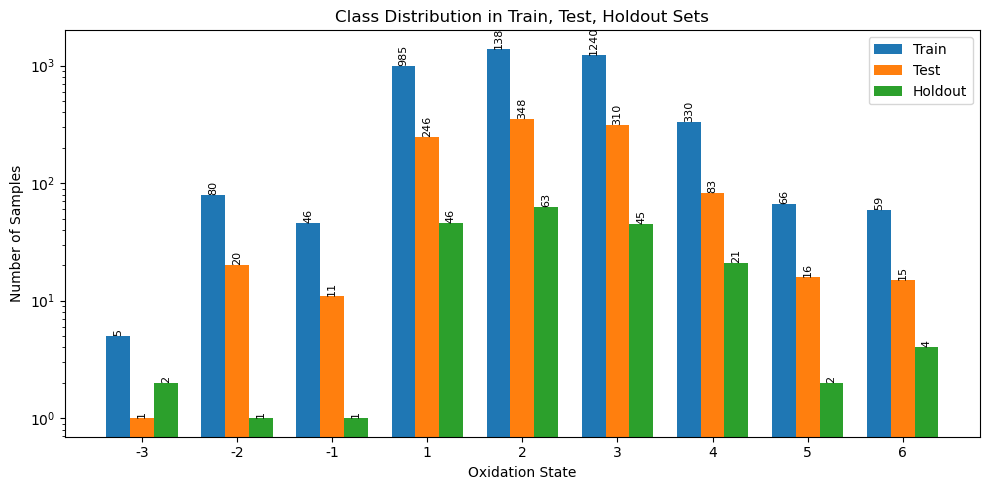

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bar_width = 0.25
classes = sorted(set(y_full))
x = np.arange(len(classes))

bars_train = plt.bar(x - bar_width, [train_counts.get(i, 0) for i in classes], width=bar_width, label="Train")
bars_test = plt.bar(x, [test_counts.get(i, 0) for i in classes], width=bar_width, label="Test")
bars_holdout = plt.bar(x + bar_width, [holdout_counts.get(i, 0) for i in classes], width=bar_width, label="Holdout")

plt.xticks(x, classes)
plt.xlabel("Oxidation State")
plt.ylabel("Number of Samples")
plt.yscale('log')
plt.legend()
plt.title("Class Distribution in Train, Test, Holdout Sets")

# Annotate bar heights
for bars in [bars_train, bars_test, bars_holdout]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height, f"{int(height)}", 
                     ha='center', va='bottom', fontsize=8, rotation=90, clip_on=True)

plt.tight_layout()
plt.show()

In [ ]:
# print("Type of y_train:", type(y_train))
# print("First 10 values:", y_train[:10])
# print("Unique values in y_train:", pd.Series(y_train).unique())
# print("dtype of y_train:", y_train.dtype)

Type of y_train: <class 'pandas.core.series.Series'>
First 10 values: 1153   -0.333333
2379    1.000000
4912    2.000000
1405    3.000000
4935    2.000000
3306    3.000000
704     2.000000
382     3.000000
1352    1.000000
908     2.000000
Name: oxidationstate, dtype: float64
Unique values in y_train: [-0.33333333  1.          2.          3.          4.         -1.5
 -1.         -2.          5.          2.5         1.5         1.33333333
 -0.66666667  6.          3.5         2.66666667 -3.          4.5
  1.25       -0.4        -0.6        -0.5        -0.2         2.25
  0.33333333]
dtype of y_train: float64


# Model rebuilding

**Step 0: Lets view the Pre-trained Models architecture**

In [7]:
import joblib

voting_clf = joblib.load("votingclassifier.joblib")

print("\nAttributes in loaded VotingClassifier:")
print(dir(voting_clf))



Attributes in loaded VotingClassifier:
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_calibrate_base_estimators', '_calibrate_model', '_check_is_fitted', '_collect_probas', '_estimators', '_fit', '_predict', '_predict_proba', '_voting_agreement', 'calibrated', 'calibration', 'classes', 'estimators', 'fit', 'lb', 'named_estimators', 'predict', 'predict_proba', 'refitted', 'transform', 'voting', 'weights']


In [8]:
# Access the private _estimators attribute (list of fitted models)
for idx, model in enumerate(voting_clf._estimators):
    print(f"\nBase estimator {idx+1}: {type(model)}")
    # Handle calibration wrapper
    if hasattr(model, "base_estimator"):
        real_model = model.base_estimator
        print(f"  Wrapped estimator: {type(real_model)}")
        params = real_model.get_params()
    else:
        params = model.get_params()
    # Print all params (or filter to wanted ones)
    for k, v in params.items():
        print(f"    {k}: {v}")


Base estimator 1: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
    alpha: 5.954890310099445e-06
    average: False
    class_weight: None
    early_stopping: False
    epsilon: 0.1
    eta0: 0.0011689827515438593
    fit_intercept: True
    l1_ratio: 0.11423006697769691
    learning_rate: optimal
    loss: log
    max_iter: 148296682.0
    n_iter_no_change: 5
    n_jobs: 1
    penalty: l1
    power_t: 0.3492346986195838
    random_state: 4
    shuffle: True
    tol: 2.920642161725428e-05
    validation_fraction: 0.1
    verbose: False
    warm_start: False

Base estimator 2: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
    algorithm: auto
    leaf_size: 30
    metric: manhattan
    metric_params: None
    n_jobs: 1
    n_neighbors: 5
    p: 1
    weights: distance

Base estimator 3: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
    ccp_alpha: None
    criterion: friedman_mse
    init: None
    learning_rate: 0.5701991664291002
    l

**Step 1: Naive Ensemble**

In [5]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Base models with default parameters
clf_et = ExtraTreesClassifier(random_state=42)
clf_gb = GradientBoostingClassifier(random_state=42)
clf_knn = KNeighborsClassifier()
clf_sgd = SGDClassifier(loss="log", random_state=42)  

# 2. Ensemble with soft voting
ensemble = VotingClassifier(
    estimators=[
        ('et', clf_et),
        ('gb', clf_gb),
        ('knn', clf_knn),
        ('sgd', clf_sgd)
    ],
    voting='soft'
)

# 3. Train ensemble on training data
ensemble.fit(X_train_clean, y_train)

# 4. Evaluate on test set
y_pred = ensemble.predict(X_test_clean)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test accuracy: 0.7904761904761904
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.79      0.75      0.77        20
          -1       1.00      0.45      0.62        11
           1       0.88      0.89      0.88       246
           2       0.86      0.83      0.84       348
           3       0.77      0.83      0.80       310
           4       0.73      0.36      0.48        83
           5       0.64      0.44      0.52        16
           6       0.67      0.53      0.59        15

    accuracy                           0.79      1050
   macro avg       0.70      0.57      0.61      1050
weighted avg       0.82      0.79      0.80      1050



**Step-2: Checking the usage of their hyperparametrs for my dataset**

In [8]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

# Base estimator 1: SGDClassifier
clf_sgd = SGDClassifier(
    alpha=5.954890310099445e-06,
    average=False,
    class_weight=None,
    early_stopping=False,
    epsilon=0.1,
    eta0=0.0011689827515438593,
    fit_intercept=True,
    l1_ratio=0.11423006697769691,
    learning_rate='optimal',
    loss='log',
    max_iter=int(1000),  # very high value as in paper
    n_iter_no_change=5,
    n_jobs=1,
    penalty='l1',
    power_t=0.3492346986195838,
    random_state=42,
    shuffle=True,
    tol=2.920642161725428e-05,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False
)

# Base estimator 2: KNeighborsClassifier
clf_knn = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=30,
    metric='manhattan',
    metric_params=None,
    n_jobs=1,
    n_neighbors=5,
    p=1,
    weights='distance'
)

# Base estimator 3: GradientBoostingClassifier
clf_gb = GradientBoostingClassifier(
    criterion='friedman_mse',
    learning_rate=0.5701991664291002,
    loss='deviance',
    max_depth=None,
    max_features=0.7464303342226334,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=23,
    subsample=0.5877820703480312,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False,
    random_state=42
)

# Base estimator 4: ExtraTreesClassifier
clf_et = ExtraTreesClassifier(
    criterion='gini',
    max_depth=None,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=64,  # this is standard for their implementation
    random_state=42
)

# Voting ensemble as in the paper
ensemble = VotingClassifier(
    estimators=[
        ('sgd', clf_sgd),
        ('knn', clf_knn),
        ('gb', clf_gb),
        ('et', clf_et)
    ],
    voting='soft'
)

# Fit and evaluate
ensemble.fit(X_train_clean, y_train)
y_pred = ensemble.predict(X_test_clean)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test accuracy: 0.7152380952380952
              precision    recall  f1-score   support

          -3       0.01      1.00      0.01         1
          -2       0.83      0.50      0.62        20
          -1       0.62      0.45      0.53        11
           1       0.92      0.81      0.86       246
           2       0.85      0.74      0.79       348
           3       0.81      0.74      0.77       310
           4       0.73      0.43      0.55        83
           5       0.75      0.38      0.50        16
           6       0.70      0.47      0.56        15

    accuracy                           0.72      1050
   macro avg       0.69      0.61      0.58      1050
weighted avg       0.84      0.72      0.77      1050



***Tuning individual base models***

**1. GradientBoostingClassifier**

In [10]:
from hyperopt import fmin, tpe, rand, anneal, hp, Trials, STATUS_OK
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Define search space as in the paper (SI Table 3)
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1.0)),
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 150, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_features': hp.uniform('max_features', 0.3, 1.0),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 8, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 12, 1),
}

def objective(params):
    # Convert float hyperopt params to int where needed
    params = params.copy()
    for k in ['max_depth', 'n_estimators', 'min_samples_leaf', 'min_samples_split']:
        params[k] = int(params[k])
    model = GradientBoostingClassifier(random_state=0, **params)
    score = cross_val_score(model, X_train_clean, y_train, cv=3, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
n_total = 500  # set 500 for paper fidelity, 100 for speed in demo
n_tpe = int(0.8 * n_total)
n_rand = int(0.1 * n_total)
n_anneal = n_total - n_tpe - n_rand

# 1. TPE phase
best_tpe = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_tpe,
    trials=trials,
    rstate=np.random.default_rng(42)
)
# 2. Random phase
best_rand = fmin(
    fn=objective,
    space=space,
    algo=rand.suggest,
    max_evals=n_tpe + n_rand,
    trials=trials,
    rstate=np.random.default_rng(43)
)
# 3. Annealing phase
best_anneal = fmin(
    fn=objective,
    space=space,
    algo=anneal.suggest,
    max_evals=n_total,
    trials=trials,
    rstate=np.random.default_rng(44)
)

# Find best parameters from all trials
best_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params = trials.trials[best_idx]['misc']['vals']
final_params = {k: v[0] for k, v in best_params.items()}
# int-cast for integer params
for k in ['max_depth', 'n_estimators', 'min_samples_leaf', 'min_samples_split']:
    final_params[k] = int(final_params[k])
print("Best Hyperopt params for GradientBoosting:", final_params)

# Train/evaluate model on full train/test
gb_best = GradientBoostingClassifier(random_state=0, **final_params)
gb_best.fit(X_train_clean, y_train)
y_pred_gb = gb_best.predict(X_test_clean)

from sklearn.metrics import accuracy_score, classification_report
print("Test accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

100%|██████████| 500/500 [2:36:09<00:00, 187.39s/trial, best loss: -0.8680952380952381]  
Best Hyperopt params for GradientBoosting: {'learning_rate': 0.07015351058361705, 'max_depth': 12, 'max_features': 0.5114056705372313, 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 129, 'subsample': 0.9116608003829677}
Test accuracy: 0.8933333333333333
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.83      0.95      0.88        20
          -1       0.89      0.73      0.80        11
           1       0.94      0.97      0.95       246
           2       0.91      0.91      0.91       348
           3       0.87      0.92      0.90       310
           4       0.86      0.61      0.72        83
           5       0.73      0.69      0.71        16
           6       0.69      0.60      0.64        15

    accuracy                           0.89      1050
   macro avg       0.75      0.71      0.72

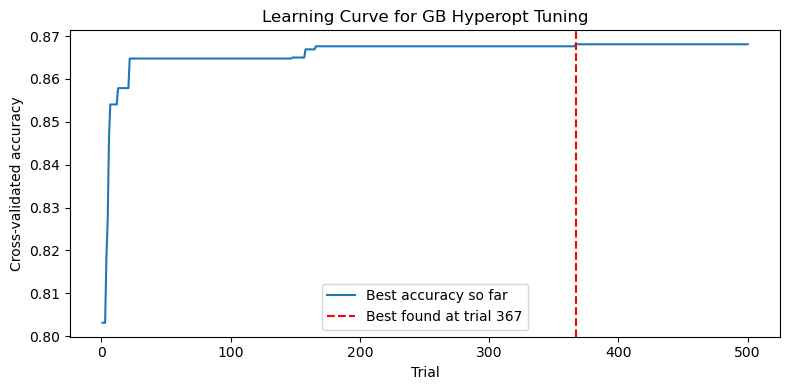

Best score: 0.8681 at trial 367


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extract losses (negative accuracy, so best is min(loss))
losses = [-t['result']['loss'] for t in trials.trials]  # Assuming 'trials' is your GB Trials object

# Cumulative best (max so far)
cummax = np.maximum.accumulate(losses)

# Trial when best found
best_trial_idx = np.argmax(losses)
best_trial_score = losses[best_trial_idx]

# Plot learning curve
plt.figure(figsize=(8,4))
plt.plot(range(1, len(cummax)+1), cummax, label='Best accuracy so far')
plt.xlabel('Trial')
plt.ylabel('Cross-validated accuracy')
plt.title('Learning Curve for GB Hyperopt Tuning')
plt.axvline(best_trial_idx+1, color='r', linestyle='--', label=f'Best found at trial {best_trial_idx+1}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best score: {best_trial_score:.4f} at trial {best_trial_idx+1}")

**2. Extra trees classifier**  
n_iter = 400 for saving some time.

In [14]:
from hyperopt import fmin, tpe, rand, anneal, hp, Trials, STATUS_OK
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

space_et = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'max_features': hp.uniform('max_features', 0.3, 1.0),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 8, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 12, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
}

def objective_et(params):
    params = params.copy()
    params['n_estimators'] = int(params['n_estimators'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    params['min_samples_split'] = int(params['min_samples_split'])
    model = ExtraTreesClassifier(random_state=0, **params)
    score = cross_val_score(model, X_train_clean, y_train, cv=3, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials_et = Trials()
n_total = 500  # 500 in the paper

n_tpe = int(0.8 * n_total)
n_rand = int(0.1 * n_total)
n_anneal = n_total - n_tpe - n_rand

# TPE
fmin(objective_et, space_et, algo=tpe.suggest, max_evals=n_tpe, trials=trials_et, rstate=np.random.default_rng(42))
# Random
fmin(objective_et, space_et, algo=rand.suggest, max_evals=n_tpe + n_rand, trials=trials_et, rstate=np.random.default_rng(43))
# Annealing
fmin(objective_et, space_et, algo=anneal.suggest, max_evals=n_total, trials=trials_et, rstate=np.random.default_rng(44))

best_idx = np.argmin([t['result']['loss'] for t in trials_et.trials])
best_params = trials_et.trials[best_idx]['misc']['vals']
final_params = {k: v[0] if isinstance(v, list) else v for k, v in best_params.items()}
final_params['n_estimators'] = int(final_params['n_estimators'])
final_params['min_samples_leaf'] = int(final_params['min_samples_leaf'])
final_params['min_samples_split'] = int(final_params['min_samples_split'])
final_params['criterion'] = ['gini', 'entropy'][final_params['criterion']]
print("Best Hyperopt params for ExtraTrees:", final_params)

et_best = ExtraTreesClassifier(random_state=0, **final_params)
et_best.fit(X_train_clean, y_train)
y_pred_et = et_best.predict(X_test_clean)
print("Test accuracy:", accuracy_score(y_test, y_pred_et))
print(classification_report(y_test, y_pred_et))

100%|██████████| 500/500 [03:57<00:00,  4.75s/trial, best loss: -0.8611904761904762]
Best Hyperopt params for ExtraTrees: {'criterion': 'entropy', 'max_features': 0.6917810676482335, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 59}
Test accuracy: 0.8819047619047619
              precision    recall  f1-score   support

          -3       1.00      1.00      1.00         1
          -2       0.79      0.95      0.86        20
          -1       0.71      0.91      0.80        11
           1       0.95      0.96      0.96       246
           2       0.91      0.91      0.91       348
           3       0.87      0.89      0.88       310
           4       0.74      0.64      0.68        83
           5       0.67      0.62      0.65        16
           6       0.64      0.47      0.54        15

    accuracy                           0.88      1050
   macro avg       0.81      0.82      0.81      1050
weighted avg       0.88      0.88      0.88      1050



**3. KNeighborsClassifier**

In [15]:
from sklearn.neighbors import KNeighborsClassifier

space_knn = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 20, 1),
    'leaf_size': hp.quniform('leaf_size', 10, 100, 1),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'p': hp.choice('p', [1, 2]),
    'metric': hp.choice('metric', ['manhattan', 'euclidean']),
}

def objective_knn(params):
    params = params.copy()
    params['n_neighbors'] = int(params['n_neighbors'])
    params['leaf_size'] = int(params['leaf_size'])
    model = KNeighborsClassifier(**params)
    score = cross_val_score(model, X_train_clean, y_train, cv=3, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials_knn = Trials()
n_total = 500
n_tpe = int(0.8 * n_total)
n_rand = int(0.1 * n_total)
n_anneal = n_total - n_tpe - n_rand

# TPE
fmin(objective_knn, space_knn, algo=tpe.suggest, max_evals=n_tpe, trials=trials_knn, rstate=np.random.default_rng(42))
# Random
fmin(objective_knn, space_knn, algo=rand.suggest, max_evals=n_tpe + n_rand, trials=trials_knn, rstate=np.random.default_rng(43))
# Annealing
fmin(objective_knn, space_knn, algo=anneal.suggest, max_evals=n_total, trials=trials_knn, rstate=np.random.default_rng(44))

best_idx = np.argmin([t['result']['loss'] for t in trials_knn.trials])
best_params = trials_knn.trials[best_idx]['misc']['vals']
final_params = {k: v[0] if isinstance(v, list) else v for k, v in best_params.items()}
final_params['n_neighbors'] = int(final_params['n_neighbors'])
final_params['leaf_size'] = int(final_params['leaf_size'])
final_params['weights'] = ['uniform', 'distance'][final_params['weights']]
final_params['p'] = [1, 2][final_params['p']]
final_params['metric'] = ['manhattan', 'euclidean'][final_params['metric']]
print("Best Hyperopt params for KNN:", final_params)

knn_best = KNeighborsClassifier(**final_params)
knn_best.fit(X_train_clean, y_train)
y_pred_knn = knn_best.predict(X_test_clean)
print("Test accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

100%|██████████| 500/500 [02:04<00:00,  2.48s/trial, best loss: -0.6578571428571429]
Best Hyperopt params for KNN: {'leaf_size': 48, 'metric': 'manhattan', 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
Test accuracy: 0.6752380952380952
              precision    recall  f1-score   support

          -3       0.50      1.00      0.67         1
          -2       0.55      0.55      0.55        20
          -1       0.57      0.36      0.44        11
           1       0.74      0.70      0.72       246
           2       0.66      0.74      0.70       348
           3       0.69      0.68      0.69       310
           4       0.56      0.48      0.52        83
           5       0.54      0.44      0.48        16
           6       0.46      0.40      0.43        15

    accuracy                           0.68      1050
   macro avg       0.59      0.59      0.58      1050
weighted avg       0.67      0.68      0.67      1050



**4. SGDClassifier (Logistic/Linear Classifier)**

In [16]:
from sklearn.linear_model import SGDClassifier

space_sgd = {
    'alpha': hp.loguniform('alpha', np.log(1e-6), np.log(1e-2)),
    'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet']),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1.0),
    'learning_rate': hp.choice('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
    'eta0': hp.loguniform('eta0', np.log(1e-4), np.log(1e-1)),
    'max_iter': hp.quniform('max_iter', 1000, 50000, 1000),
    'tol': hp.loguniform('tol', np.log(1e-6), np.log(1e-2))
}

def objective_sgd(params):
    params = params.copy()
    params['max_iter'] = int(params['max_iter'])
    model = SGDClassifier(loss='log', random_state=42, **params)
    score = cross_val_score(model, X_train_clean, y_train, cv=3, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials_sgd = Trials()
n_total = 500
n_tpe = int(0.8 * n_total)
n_rand = int(0.1 * n_total)
n_anneal = n_total - n_tpe - n_rand

# TPE
fmin(objective_sgd, space_sgd, algo=tpe.suggest, max_evals=n_tpe, trials=trials_sgd, rstate=np.random.default_rng(42))
# Random
fmin(objective_sgd, space_sgd, algo=rand.suggest, max_evals=n_tpe + n_rand, trials=trials_sgd, rstate=np.random.default_rng(43))
# Annealing
fmin(objective_sgd, space_sgd, algo=anneal.suggest, max_evals=n_total, trials=trials_sgd, rstate=np.random.default_rng(44))

best_idx = np.argmin([t['result']['loss'] for t in trials_sgd.trials])
best_params = trials_sgd.trials[best_idx]['misc']['vals']
final_params = {k: v[0] if isinstance(v, list) else v for k, v in best_params.items()}
final_params['penalty'] = ['l1', 'l2', 'elasticnet'][final_params['penalty']]
final_params['learning_rate'] = ['constant', 'optimal', 'invscaling', 'adaptive'][final_params['learning_rate']]
final_params['max_iter'] = int(final_params['max_iter'])
print("Best Hyperopt params for SGDClassifier:", final_params)

sgd_best = SGDClassifier(loss='log', random_state=42, **final_params)
sgd_best.fit(X_train_clean, y_train)
y_pred_sgd = sgd_best.predict(X_test_clean)
print("Test accuracy:", accuracy_score(y_test, y_pred_sgd))
print(classification_report(y_test, y_pred_sgd))

100%|██████████| 500/500 [04:17<00:00,  5.15s/trial, best loss: -0.49500000000000005]
Best Hyperopt params for SGDClassifier: {'alpha': 4.0212149576865536e-05, 'eta0': 0.07050171813288647, 'l1_ratio': 0.24236385892113504, 'learning_rate': 'invscaling', 'max_iter': 38000, 'penalty': 'elasticnet', 'tol': 4.582974403364687e-05}
Test accuracy: 0.5257142857142857
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.31      0.40      0.35        20
          -1       0.33      0.09      0.14        11
           1       0.64      0.48      0.55       246
           2       0.67      0.55      0.61       348
           3       0.43      0.71      0.54       310
           4       0.27      0.07      0.11        83
           5       0.29      0.12      0.17        16
           6       0.38      0.20      0.26        15

    accuracy                           0.53      1050
   macro avg       0.37      0.29      0.30

**Tuned Ensemble in action**

In [10]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

# Inserted best parameters from your optimization results:
final_params_gb = {
    'learning_rate': 0.07015351058361705,
    'max_depth': 12,
    'max_features': 0.5114056705372313,
    'min_samples_leaf': 6,
    'min_samples_split': 12,
    'n_estimators': 129,
    'subsample': 0.9116608003829677
}
final_params_et = {
    'criterion': 'entropy',
    'max_features': 0.6917810676482335,
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 59
}
final_params_knn = {
    'leaf_size': 48,
    'metric': 'manhattan',
    'n_neighbors': 4,
    'p': 2,
    'weights': 'distance'
}
final_params_sgd = {
    'alpha': 4.0212149576865536e-05,
    'eta0': 0.07050171813288647,
    'l1_ratio': 0.24236385892113504,
    'learning_rate': 'invscaling',
    'max_iter': 38000,
    'penalty': 'elasticnet',
    'tol': 4.582974403364687e-05
}

# Build base estimators
clf_gb = GradientBoostingClassifier(random_state=0, **final_params_gb)
clf_et = ExtraTreesClassifier(random_state=0, **final_params_et)
clf_knn = KNeighborsClassifier(**final_params_knn)
clf_sgd = SGDClassifier(loss='log', random_state=42, **final_params_sgd)

# Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('gb', clf_gb),
        ('et', clf_et),
        ('knn', clf_knn),
        ('sgd', clf_sgd)
    ],
    voting='soft'
)

# Train and evaluate
ensemble.fit(X_train_clean, y_train)

# Test set evaluation
y_pred = ensemble.predict(X_test_clean)
print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Holdout set evaluation
y_pred_holdout = ensemble.predict(X_holdout_clean)
print("\nHoldout accuracy:", accuracy_score(y_holdout, y_pred_holdout))
print(classification_report(y_holdout, y_pred_holdout))


Test accuracy: 0.8828571428571429
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.86      0.95      0.90        20
          -1       0.89      0.73      0.80        11
           1       0.95      0.97      0.96       246
           2       0.90      0.91      0.90       348
           3       0.83      0.92      0.87       310
           4       0.86      0.53      0.66        83
           5       0.77      0.62      0.69        16
           6       0.73      0.53      0.62        15

    accuracy                           0.88      1050
   macro avg       0.75      0.68      0.71      1050
weighted avg       0.88      0.88      0.88      1050


Holdout accuracy: 0.8594594594594595
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         2
          -2       1.00      1.00      1.00         1
          -1       0.00      0.00      0.00         1
     

*Weighting the models' contributions*

In [11]:
# VotingClassifier with custom weights
ensemble = VotingClassifier(
    estimators=[
        ('gb', clf_gb),
        ('et', clf_et),
        ('knn', clf_knn),
        ('sgd', clf_sgd)
    ],
    voting='soft',
    weights=[10.0, 10.0, 0.1, 0.1]  # GB, ET, kNN, SGD
)

# Train and evaluate
ensemble.fit(X_train_clean, y_train)

# Test set
y_pred = ensemble.predict(X_test_clean)
print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Holdout set
y_pred_holdout = ensemble.predict(X_holdout_clean)
print("\nHoldout accuracy:", accuracy_score(y_holdout, y_pred_holdout))
print(classification_report(y_holdout, y_pred_holdout))


Test accuracy: 0.8933333333333333
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.83      0.95      0.88        20
          -1       0.89      0.73      0.80        11
           1       0.94      0.97      0.95       246
           2       0.91      0.92      0.91       348
           3       0.88      0.92      0.90       310
           4       0.82      0.59      0.69        83
           5       0.77      0.62      0.69        16
           6       0.67      0.53      0.59        15

    accuracy                           0.89      1050
   macro avg       0.74      0.69      0.71      1050
weighted avg       0.89      0.89      0.89      1050


Holdout accuracy: 0.8918918918918919
              precision    recall  f1-score   support

          -3       1.00      1.00      1.00         2
          -2       0.50      1.00      0.67         1
          -1       0.00      0.00      0.00         1
     

**Shap Global feature importances for ExtraTreesClassifier*

In [20]:
print(X_train_clean.shape)

(4200, 137)


In [12]:
import shap
import numpy as np

# Fit the best ExtraTreesClassifier
clf_et.fit(X_train_clean, y_train)

# Get SHAP values (multi-class supported)
explainer = shap.TreeExplainer(clf_et)
shap_values = explainer.shap_values(X_test_clean)
feature_names = X_full.columns

# Global importance: mean(|SHAP|) across classes
if isinstance(shap_values, list):
    mean_abs_shap = np.mean([np.abs(vals).mean(axis=0) for vals in shap_values], axis=0)
else:
    mean_abs_shap = np.abs(shap_values).mean(axis=0)

sorted_idx = np.argsort(mean_abs_shap)[::-1]
shap_feature_order = feature_names[sorted_idx].tolist()

print("Top 10 SHAP-ranked features:", shap_feature_order[:10])
print("Total features ranked:", len(shap_feature_order))

Top 10 SHAP-ranked features: ['column', 'valenceelectrons', 'diffto18electrons', 'dunfilled', 'Z', 'local signed difference in NfUnfilled', 'maximum local difference in MendeleevNumber', 'sunfilled', 'maximum local difference in Column', 'local signed difference in Column']
Total features ranked: 137


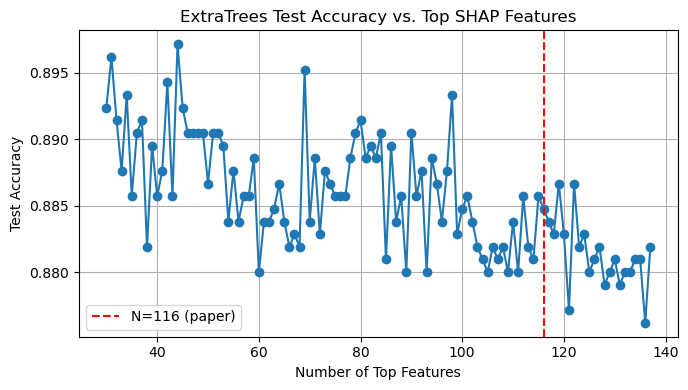


Best accuracy 0.8971 achieved with top 44 features.
Top 10 of the top 116 features: ['column', 'valenceelectrons', 'diffto18electrons', 'dunfilled', 'Z', 'local signed difference in NfUnfilled', 'maximum local difference in MendeleevNumber', 'sunfilled', 'maximum local difference in Column', 'local signed difference in Column']


In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

results = []
n_feat_total = len(shap_feature_order)
steps = list(range(30, n_feat_total+1, 1))
if 116 not in steps:
    steps.append(116)
steps = sorted(set(steps))  # Remove duplicates, ensure order

for top_n in steps:
    selected = shap_feature_order[:top_n]
    X_train_top = pd.DataFrame(X_train_clean, columns=feature_names)[selected]
    X_test_top = pd.DataFrame(X_test_clean, columns=feature_names)[selected]

    clf_et_top = ExtraTreesClassifier(random_state=0, **final_params_et)
    clf_et_top.fit(X_train_top, y_train)
    y_pred_top = clf_et_top.predict(X_test_top)
    acc = accuracy_score(y_test, y_pred_top)
    results.append((top_n, acc))
    #print(f"Top {top_n} features: Test accuracy = {acc:.4f}")

# Plot
x, y_ = zip(*results)
plt.figure(figsize=(7,4))
plt.plot(x, y_, marker='o')
plt.xlabel("Number of Top Features")
plt.ylabel("Test Accuracy")
plt.title("ExtraTrees Test Accuracy vs. Top SHAP Features")
plt.axvline(116, color='red', linestyle='--', label='N=116 (paper)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find optimal feature count
best_n, best_acc = max(results, key=lambda t: t[1])
print(f"\nBest accuracy {best_acc:.4f} achieved with top {best_n} features.")

# Final: Save top 116 feature names for the last ensemble
top116_features = shap_feature_order[:116]
print("Top 10 of the top 116 features:", top116_features[:10])

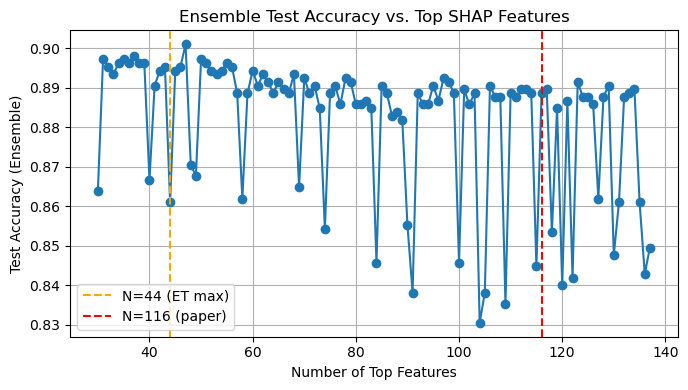


Best ensemble accuracy 0.9010 achieved with top 47 features.


In [27]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

results_ens = []
steps = list(range(30, len(shap_feature_order)+1, 1))
if 44 not in steps:
    steps.append(44)
if 116 not in steps:
    steps.append(116)
if steps[-1] != len(shap_feature_order):
    steps.append(len(shap_feature_order))

steps = sorted(set(steps))

for top_n in steps:
    selected = shap_feature_order[:top_n]
    X_train_top = pd.DataFrame(X_train_clean, columns=feature_names)[selected]
    X_test_top = pd.DataFrame(X_test_clean, columns=feature_names)[selected]

    # Use your tuned ensemble with custom weights if desired
    ensemble = VotingClassifier(
        estimators=[
            ('gb', clf_gb),
            ('et', clf_et),
            ('knn', clf_knn),
            ('sgd', clf_sgd)
        ],
        voting='soft',
        weights=[0.7, 0.7, 0.4, 0.4]
    )

    ensemble.fit(X_train_top, y_train)
    y_pred_ens = ensemble.predict(X_test_top)
    acc_ens = accuracy_score(y_test, y_pred_ens)
    results_ens.append((top_n, acc_ens))
    #print(f"Top {top_n} features: Ensemble test accuracy = {acc_ens:.4f}")

# Plotting
x_ens, y_ens = zip(*results_ens)
plt.figure(figsize=(7,4))
plt.plot(x_ens, y_ens, marker='o')
plt.xlabel("Number of Top Features")
plt.ylabel("Test Accuracy (Ensemble)")
plt.title("Ensemble Test Accuracy vs. Top SHAP Features")
plt.axvline(44, color='orange', linestyle='--', label='N=44 (ET max)')
plt.axvline(116, color='red', linestyle='--', label='N=116 (paper)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best N for ensemble
best_n_ens, best_acc_ens = max(results_ens, key=lambda t: t[1])
print(f"\nBest ensemble accuracy {best_acc_ens:.4f} achieved with top {best_n_ens} features.")

**Ensemble performance if the features are optimized for ExtraTrees classifier**

In [ ]:
# Use only the top 44 SHAP-ranked (for extra trees) features!!
final_features = shap_feature_order[:44]

X_train_final = pd.DataFrame(X_train_clean, columns=feature_names)[final_features]
X_test_final = pd.DataFrame(X_test_clean, columns=feature_names)[final_features]
X_holdout_final = pd.DataFrame(X_holdout_clean, columns=feature_names)[final_features]
# Re-create tuned models (using your best found parameters)
clf_gb = GradientBoostingClassifier(random_state=0, **final_params_gb)
clf_et = ExtraTreesClassifier(random_state=0, **final_params_et)
clf_knn = KNeighborsClassifier(**final_params_knn)
clf_sgd = SGDClassifier(loss='log', random_state=42, **final_params_sgd)

# (Optional) Use custom weights, e.g. [0.7, 0.7, 0.4, 0.4]
ensemble = VotingClassifier(
    estimators=[
        ('gb', clf_gb),
        ('et', clf_et),
        ('knn', clf_knn),
        ('sgd', clf_sgd)
    ],
    voting='soft',
    weights=[10, 10, 0.1, 0.1]
)

ensemble.fit(X_train_final, y_train)

# Test set
y_pred = ensemble.predict(X_test_final)
print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Holdout set
y_pred_holdout = ensemble.predict(X_holdout_final)
print("\nHoldout accuracy:", accuracy_score(y_holdout, y_pred_holdout))
print(classification_report(y_holdout, y_pred_holdout))


Test accuracy: 0.8095238095238095
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.64      0.80      0.71        20
          -1       0.27      0.55      0.36        11
           1       0.88      0.90      0.89       246
           2       0.87      0.84      0.86       348
           3       0.83      0.83      0.83       310
           4       0.63      0.49      0.55        83
           5       0.32      0.50      0.39        16
           6       0.57      0.53      0.55        15

    accuracy                           0.81      1050
   macro avg       0.56      0.60      0.57      1050
weighted avg       0.82      0.81      0.81      1050


Holdout accuracy: 0.7783783783783784
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         2
          -2       0.00      0.00      0.00         1
          -1       0.00      0.00      0.00         1
     

**Ensemble performance if the features are optimized for the Ensemble**

In [14]:
final_features_ensemble = shap_feature_order[:47]

X_train_final = pd.DataFrame(X_train_clean, columns=feature_names)[final_features_ensemble]
X_test_final = pd.DataFrame(X_test_clean, columns=feature_names)[final_features_ensemble]
X_holdout_final = pd.DataFrame(X_holdout_clean, columns=feature_names)[final_features_ensemble]

ensemble = VotingClassifier(
    estimators=[
        ('gb', clf_gb),
        ('et', clf_et),
        ('knn', clf_knn),
        ('sgd', clf_sgd)
    ],
    voting='soft',
    weights=[0.7, 0.7, 0.4, 0.4]
)

ensemble.fit(X_train_final, y_train)

# Test set
y_pred = ensemble.predict(X_test_final)
print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Holdout set
y_pred_holdout = ensemble.predict(X_holdout_final)
print("\nHoldout accuracy:", accuracy_score(y_holdout, y_pred_holdout))
print(classification_report(y_holdout, y_pred_holdout))


Test accuracy: 0.900952380952381
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.86      0.95      0.90        20
          -1       0.89      0.73      0.80        11
           1       0.94      0.97      0.96       246
           2       0.91      0.93      0.92       348
           3       0.90      0.92      0.91       310
           4       0.82      0.64      0.72        83
           5       0.85      0.69      0.76        16
           6       0.58      0.47      0.52        15

    accuracy                           0.90      1050
   macro avg       0.75      0.70      0.72      1050
weighted avg       0.90      0.90      0.90      1050


Holdout accuracy: 0.8972972972972973
              precision    recall  f1-score   support

          -3       1.00      1.00      1.00         2
          -2       0.50      1.00      0.67         1
          -1       1.00      1.00      1.00         1
      

**Tuning the Voting classifier's hyperparameters**

In [15]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Prepare train and test sets
X_train_opt = X_train_final
X_test_opt = X_test_final

# Fix tuned base models (already fit, just need to be passed in fresh for VotingClassifier)
clf_gb = GradientBoostingClassifier(random_state=0, **final_params_gb)
clf_et = ExtraTreesClassifier(random_state=0, **final_params_et)
clf_knn = KNeighborsClassifier(**final_params_knn)
clf_sgd = SGDClassifier(loss='log', random_state=42, **final_params_sgd)

# Define search space
space = {
    'w_gb': hp.uniform('w_gb', 1.0, 10.0),
    'w_et': hp.uniform('w_et', 1.0, 10.0),
    'w_knn': hp.uniform('w_knn', 0.1, 0.7),
    'w_sgd': hp.uniform('w_sgd', 0.1, 0.7),
    'voting_type': hp.choice('voting_type', ['soft', 'hard'])
}

def objective(params):
    weights = [params['w_gb'], params['w_et'], params['w_knn'], params['w_sgd']]
    ensemble = VotingClassifier(
        estimators=[
            ('gb', clf_gb),
            ('et', clf_et),
            ('knn', clf_knn),
            ('sgd', clf_sgd)
        ],
        voting=params['voting_type'],
        weights=weights if params['voting_type'] == 'soft' else None # weights only for 'soft'
    )
    ensemble.fit(X_train_opt, y_train)
    y_pred = ensemble.predict(X_test_opt)
    acc = accuracy_score(y_test, y_pred)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50, 
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Map voting_type back to string
voting_types = ['soft', 'hard']
best['voting_type'] = voting_types[best['voting_type']]

print("\nBest VotingClassifier params from hyperopt:")
print(best)

# Re-train best model for reporting
best_weights = [best['w_gb'], best['w_et'], best['w_knn'], best['w_sgd']]
best_ensemble = VotingClassifier(
    estimators=[
        ('gb', clf_gb),
        ('et', clf_et),
        ('knn', clf_knn),
        ('sgd', clf_sgd)
    ],
    voting=best['voting_type'],
    weights=best_weights if best['voting_type']=='soft' else None
)
best_ensemble.fit(X_train_opt, y_train)

# Test
y_pred = best_ensemble.predict(X_test_opt)
print("\nTest accuracy (optimized VotingClassifier):", accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Holdout (optional)
y_pred_holdout = best_ensemble.predict(X_holdout_final)
print("\nHoldout accuracy:", accuracy_score(y_holdout, y_pred_holdout))
print(classification_report(y_holdout, y_pred_holdout))

100%|██████████| 50/50 [43:17<00:00, 51.94s/trial, best loss: -0.9047619047619048]

Best VotingClassifier params from hyperopt:
{'voting_type': 'soft', 'w_et': 4.032817653205974, 'w_gb': 7.732321956643608, 'w_knn': 0.5980537794234883, 'w_sgd': 0.13857211798572955}

Test accuracy (optimized VotingClassifier): 0.9047619047619048
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.86      0.95      0.90        20
          -1       0.80      0.73      0.76        11
           1       0.95      0.97      0.96       246
           2       0.92      0.93      0.92       348
           3       0.90      0.93      0.91       310
           4       0.83      0.65      0.73        83
           5       0.86      0.75      0.80        16
           6       0.64      0.60      0.62        15

    accuracy                           0.90      1050
   macro avg       0.75      0.72      0.73      1050
weighted avg       0.

**Weight vs. Performance**  
*Extracting the weights*

In [16]:
import numpy as np
import pandas as pd

# Gather weights and accuracy for all completed trials
trial_weights = []
trial_accuracy = []
trial_voting_type = []

for t in trials.trials:
    vals = t['misc']['vals']
    # Get voting type as string
    vtype = ['soft', 'hard'][vals['voting_type'][0]]
    # Get weights (put None for non-soft voting)
    weights = [
        vals['w_gb'][0] if 'w_gb' in vals else np.nan,
        vals['w_et'][0] if 'w_et' in vals else np.nan,
        vals['w_knn'][0] if 'w_knn' in vals else np.nan,
        vals['w_sgd'][0] if 'w_sgd' in vals else np.nan
    ] if vtype == 'soft' else [np.nan, np.nan, np.nan, np.nan]
    trial_weights.append(weights)
    # Negative loss is accuracy
    trial_accuracy.append(-t['result']['loss'])
    trial_voting_type.append(vtype)

weights_arr = np.array(trial_weights)
accuracy_arr = np.array(trial_accuracy)
voting_type_arr = np.array(trial_voting_type)

# Convert to DataFrame for easy plotting/analysis
trial_df = pd.DataFrame(weights_arr, columns=['GB', 'ET', 'KNN', 'SGD'])
trial_df['Accuracy'] = accuracy_arr
trial_df['VotingType'] = voting_type_arr

*The Plot*

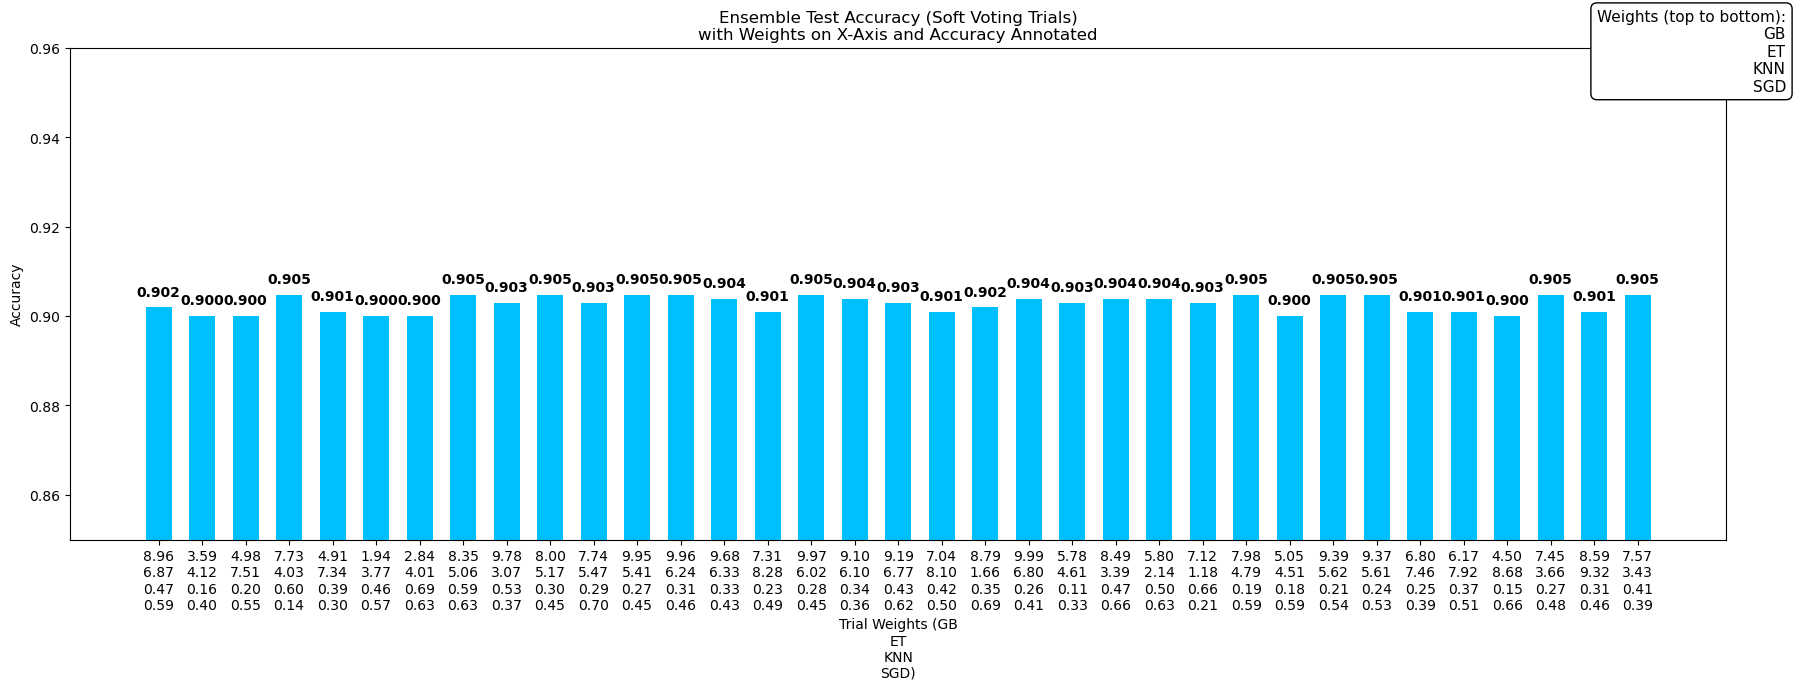

In [23]:
import matplotlib.pyplot as plt
import numpy as np

soft_df = trial_df[trial_df['VotingType'] == 'soft'].reset_index(drop=True)
x = np.arange(len(soft_df))

# Compose vertical labels for each trial
weight_labels = [
    "\n".join([f"{row['GB']:.2f}", f"{row['ET']:.2f}", f"{row['KNN']:.2f}", f"{row['SGD']:.2f}"])
    for _, row in soft_df.iterrows()
]

# Dynamically set width (but max out at 18), and make it taller
fig_width = min(18, 0.55 * len(soft_df) + 4)
plt.figure(figsize=(fig_width, 7))  # Taller plot

bars = plt.bar(x, soft_df['Accuracy'], color='deepskyblue', width=0.6)

# Annotate top of each bar with accuracy value
for idx, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.xticks(x, weight_labels, fontsize=10, ha='center', rotation=0)
plt.xlabel("Trial Weights (GB\nET\nKNN\nSGD)")
plt.ylabel("Accuracy")
plt.title("Ensemble Test Accuracy (Soft Voting Trials)\nwith Weights on X-Axis and Accuracy Annotated")
plt.ylim(
    min(soft_df['Accuracy'].min(), 0.85), 
    max(soft_df['Accuracy'].max(), 0.96)
)

# Add a custom legend for weight order (top right, outside plot)
legend_text = "Weights (top to bottom):\nGB\nET\nKNN\nSGD"
plt.gcf().text(0.995, 0.98, legend_text, ha='right', va='top', fontsize=11, 
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))

plt.tight_layout(rect=[0, 0, 0.97, 1])
plt.show()

**Whether modifying the ensemble results improvements--:**

In [24]:
# from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# # Use previously tuned GB and ET
# clf_gb = GradientBoostingClassifier(random_state=0, **final_params_gb)
# clf_et = ExtraTreesClassifier(random_state=0, **final_params_et)
# clf_lgbm = LGBMClassifier(random_state=0, n_jobs=-1)
# clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1)

# # Use same features and data
# X_train_base = X_train_final
# X_test_base = X_test_final
# X_holdout_base = X_holdout_final

# # New ensemble: GB, ET, LGBM, RF
# ensemble_new = VotingClassifier(
#     estimators=[
#         ('gb', clf_gb),
#         ('et', clf_et),
#         ('lgbm', clf_lgbm),
#         ('rf', clf_rf)
#     ],
#     voting='soft',
#     weights=[1, 1, 1, 1]  # Equal weights for a fair first test
# )

# ensemble_new.fit(X_train_base, y_train)

# # Test
# y_pred_new = ensemble_new.predict(X_test_base)
# print("\nTest accuracy (ensemble: GB+ET+LGBM+RF):", accuracy_score(y_test, y_pred_new))
# print(classification_report(y_test, y_pred_new))

# # Holdout
# y_pred_holdout_new = ensemble_new.predict(X_holdout_base)
# print("\nHoldout accuracy:", accuracy_score(y_holdout, y_pred_holdout_new))
# print(classification_report(y_holdout, y_pred_holdout_new))

**Tuning LGBM model**

In [25]:
from hyperopt import fmin, tpe, rand, anneal, hp, Trials, STATUS_OK
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

space_lgbm = {
    'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'max_depth': hp.quniform('max_depth', 2, 14, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1.0)),
    'n_estimators': hp.quniform('n_estimators', 10, 150, 1),
    'min_child_samples': hp.quniform('min_child_samples', 1, 20, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

def objective_lgbm(params):
    params = params.copy()
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_samples'] = int(params['min_child_samples'])
    model = LGBMClassifier(random_state=0,
                           n_jobs=-1,
                           verbose=-1,
                           verbosity=-1,
                           force_col_wise=True,
                           **params)
    score = cross_val_score(model, X_train_final, y_train, cv=3, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials_lgbm = Trials()
n_total = 500  

n_tpe = int(0.8 * n_total)
n_rand = int(0.1 * n_total)
n_anneal = n_total - n_tpe - n_rand

# TPE
fmin(objective_lgbm, space_lgbm, algo=tpe.suggest, max_evals=n_tpe, trials=trials_lgbm, rstate=np.random.default_rng(42))
# Random
fmin(objective_lgbm, space_lgbm, algo=rand.suggest, max_evals=n_tpe + n_rand, trials=trials_lgbm, rstate=np.random.default_rng(43))
# Annealing
fmin(objective_lgbm, space_lgbm, algo=anneal.suggest, max_evals=n_total, trials=trials_lgbm, rstate=np.random.default_rng(44))

# Extract best params
best_idx = np.argmin([t['result']['loss'] for t in trials_lgbm.trials])
vals = trials_lgbm.trials[best_idx]['misc']['vals']
final_params_lgbm = {k: v[0] if isinstance(v, list) else v for k, v in vals.items()}
for k in ['num_leaves', 'max_depth', 'n_estimators', 'min_child_samples']:
    final_params_lgbm[k] = int(final_params_lgbm[k])
print("Best Hyperopt params for LGBM:", final_params_lgbm)

100%|██████████| 500/500 [03:28<00:00,  4.18s/trial, best loss: -0.8816666666666667]
Best Hyperopt params for LGBM: {'colsample_bytree': 0.74930002721615, 'learning_rate': 0.11255831529671392, 'max_depth': 12, 'min_child_samples': 19, 'n_estimators': 125, 'num_leaves': 31, 'subsample': 0.7988355343345458}


**Tuning the random forest model**

In [32]:
from sklearn.ensemble import RandomForestClassifier

space_rf = {
    'n_estimators': hp.quniform('n_estimators', 10, 150, 1),
    'max_depth': hp.quniform('max_depth', 2, 14, 1),
    'max_features': hp.uniform('max_features', 0.3, 1.0),
    'min_samples_split': hp.quniform('min_samples_split', 2, 12, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 8, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

def objective_rf(params):
    params = params.copy()
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    # Robust mapping
    if isinstance(params['criterion'], int):
        params['criterion'] = ['gini', 'entropy'][params['criterion']]
    # If it's already a string, leave it
    model = RandomForestClassifier(random_state=0, n_jobs=-1, **params)
    score = cross_val_score(model, X_train_final, y_train, cv=3, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}


trials_rf = Trials()
n_total = 500

n_tpe = int(0.8 * n_total)
n_rand = int(0.1 * n_total)
n_anneal = n_total - n_tpe - n_rand

# TPE
fmin(objective_rf, space_rf, algo=tpe.suggest, max_evals=n_tpe, trials=trials_rf, rstate=np.random.default_rng(42))
# Random
fmin(objective_rf, space_rf, algo=rand.suggest, max_evals=n_tpe + n_rand, trials=trials_rf, rstate=np.random.default_rng(43))
# Annealing
fmin(objective_rf, space_rf, algo=anneal.suggest, max_evals=n_total, trials=trials_rf, rstate=np.random.default_rng(44))

# Extract best params
best_idx = np.argmin([t['result']['loss'] for t in trials_rf.trials])
vals = trials_rf.trials[best_idx]['misc']['vals']
final_params_rf = {k: v[0] if isinstance(v, list) else v for k, v in vals.items()}
for k in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']:
    final_params_rf[k] = int(final_params_rf[k])
final_params_rf['criterion'] = ['gini', 'entropy'][final_params_rf['criterion']]
print("Best Hyperopt params for RF:", final_params_rf)


100%|██████████| 500/500 [05:45<00:00,  6.91s/trial, best loss: -0.8564285714285714]
Best Hyperopt params for RF: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 0.5565231135764301, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


**Modified ensemble tuning**

In [33]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# 1. Define base models with tuned hyperparameters
clf_gb = GradientBoostingClassifier(random_state=0, **final_params_gb)
clf_et = ExtraTreesClassifier(random_state=0, **final_params_et)
clf_lgbm = LGBMClassifier(random_state=0, n_jobs=-1, **final_params_lgbm)
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1, **final_params_rf)

# 2. Hyperopt weight optimization (soft voting)
space = {
    'w_gb': hp.uniform('w_gb', 1.0, 10.0),
    'w_et': hp.uniform('w_et', 1.0, 10.0),
    'w_lgbm': hp.uniform('w_lgbm', 1.0, 10.0),
    'w_rf': hp.uniform('w_rf', 1.0, 10.0)
}

def objective(params):
    weights = [params['w_gb'], params['w_et'], params['w_lgbm'], params['w_rf']]
    ensemble = VotingClassifier(
        estimators=[
            ('gb', clf_gb),
            ('et', clf_et),
            ('lgbm', clf_lgbm),
            ('rf', clf_rf)
        ],
        voting='soft',
        weights=weights
    )
    ensemble.fit(X_train_final, y_train)
    y_pred = ensemble.predict(X_test_final)
    acc = accuracy_score(y_test, y_pred)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Increase if you want
    trials=trials,
    rstate=np.random.default_rng(42)
)

# 3. Use best weights for final ensemble
best_weights = [best['w_gb'], best['w_et'], best['w_lgbm'], best['w_rf']]
print("\nOptimized weights:", best_weights)

ensemble_best = VotingClassifier(
    estimators=[
        ('gb', clf_gb),
        ('et', clf_et),
        ('lgbm', clf_lgbm),
        ('rf', clf_rf)
    ],
    voting='soft',
    weights=best_weights
)
ensemble_best.fit(X_train_final, y_train)

# Test
y_pred = ensemble_best.predict(X_test_final)
print("\nTest accuracy (optimized VotingClassifier):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Holdout
y_pred_holdout = ensemble_best.predict(X_holdout_final)
print("\nHoldout accuracy:", accuracy_score(y_holdout, y_pred_holdout))
print(classification_report(y_holdout, y_pred_holdout))

100%|██████████| 50/50 [46:52<00:00, 56.25s/trial, best loss: -0.9057142857142857]

Optimized weights: [4.914981582857257, 7.337206512155174, 5.325014518401171, 3.9252915346192703]

Test accuracy (optimized VotingClassifier): 0.9057142857142857
              precision    recall  f1-score   support

          -3       1.00      1.00      1.00         1
          -2       0.83      0.95      0.88        20
          -1       0.80      0.73      0.76        11
           1       0.95      0.97      0.96       246
           2       0.91      0.93      0.92       348
           3       0.90      0.92      0.91       310
           4       0.85      0.66      0.74        83
           5       0.86      0.75      0.80        16
           6       0.64      0.60      0.62        15

    accuracy                           0.91      1050
   macro avg       0.86      0.83      0.84      1050
weighted avg       0.90      0.91      0.90      1050


Holdout accuracy: 0.9081081081081082
            

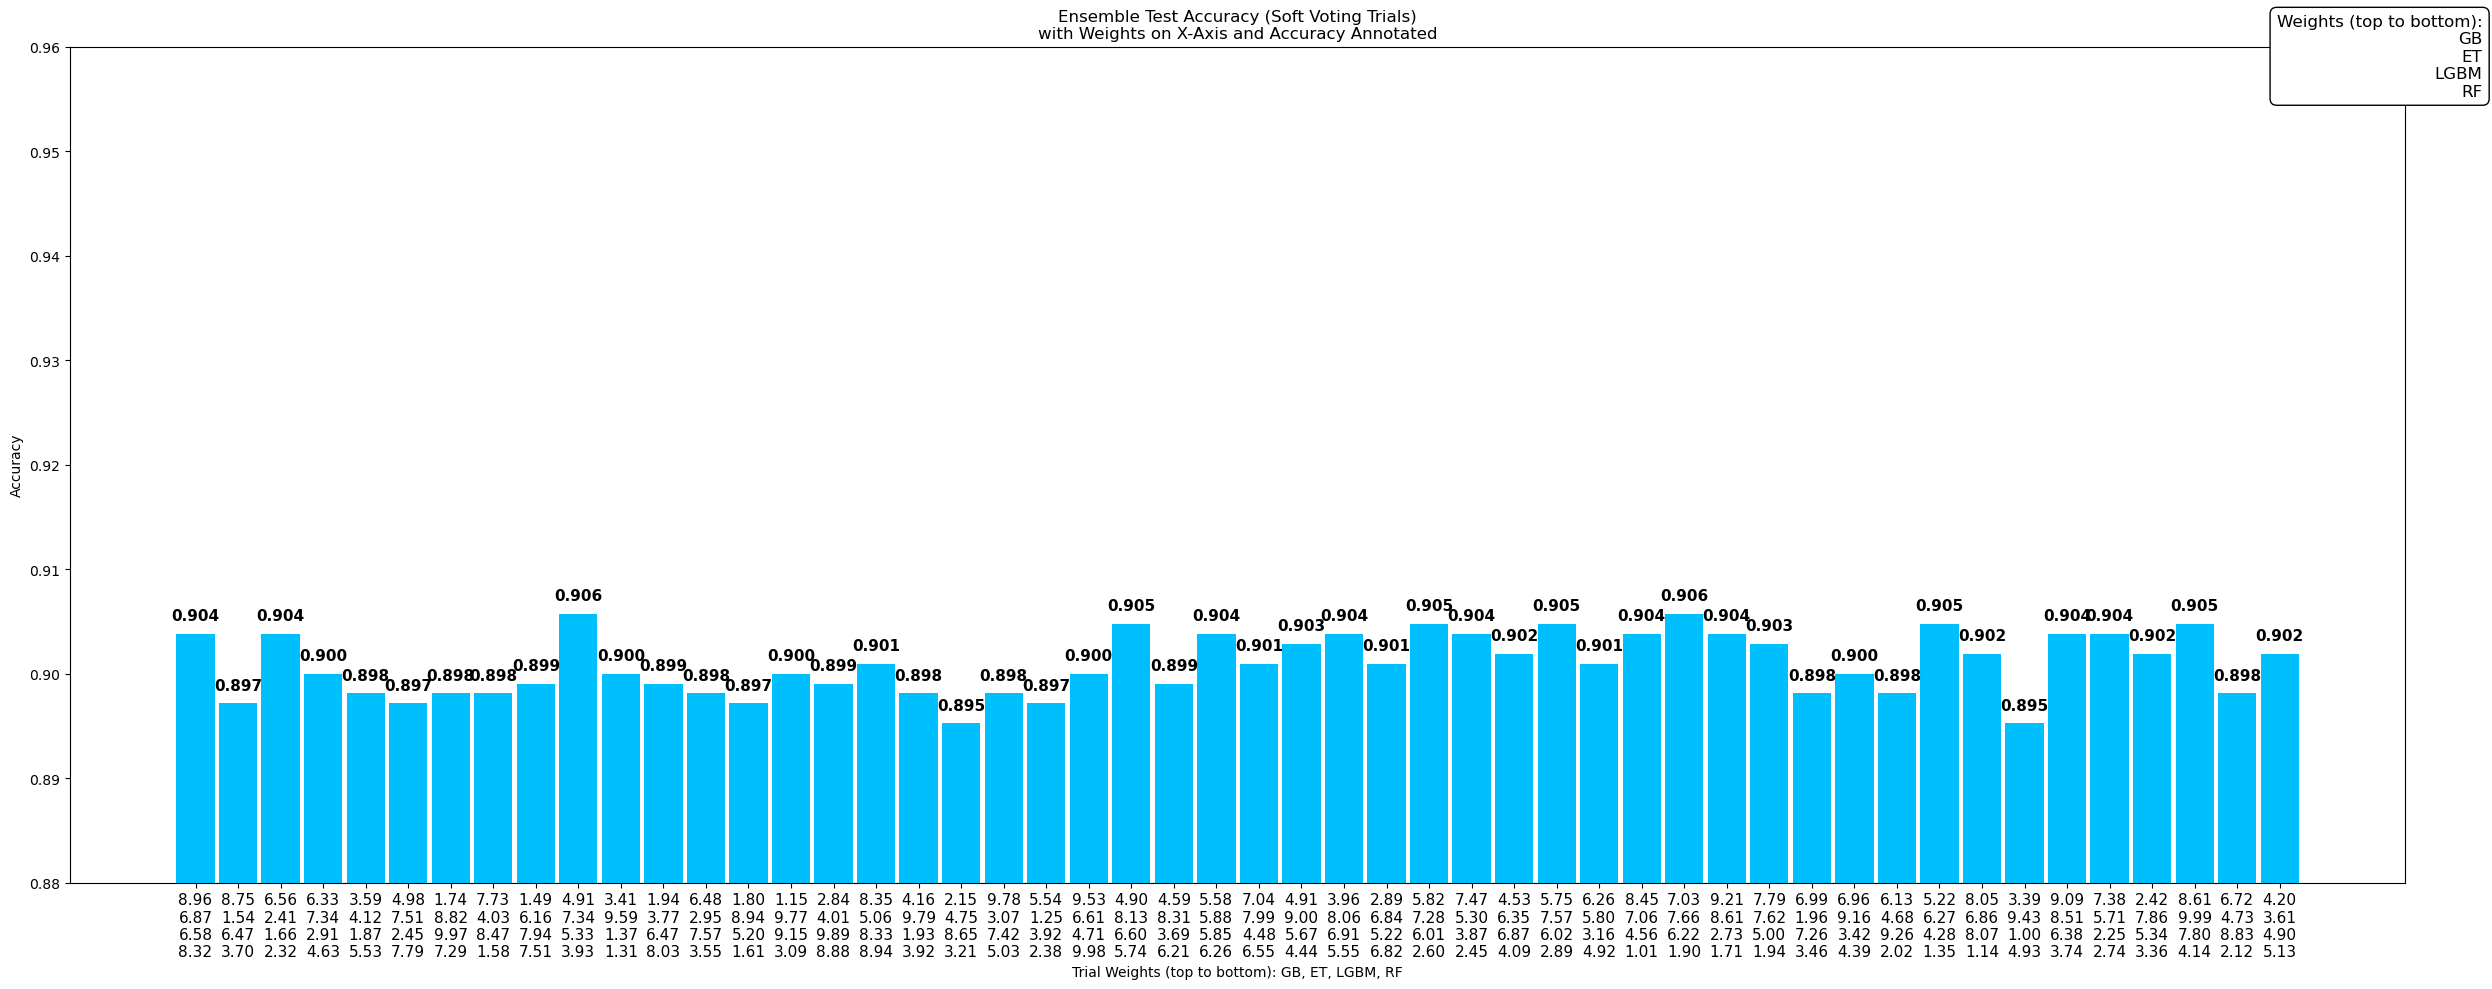

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Update this to match your new ensemble/trials structure if needed
weights_arr = []
accuracy_arr = []

for t in trials.trials:
    vals = t['misc']['vals']
    weights = [
        vals['w_gb'][0],
        vals['w_et'][0],
        vals['w_lgbm'][0],
        vals['w_rf'][0]
    ]
    weights_arr.append(weights)
    accuracy_arr.append(-t['result']['loss'])

weights_arr = np.array(weights_arr)
accuracy_arr = np.array(accuracy_arr)
labels = ['GB', 'ET', 'LGBM', 'RF']

x = np.arange(len(weights_arr))
weight_labels = [
    "\n".join([f"{w:.2f}" for w in weights_arr[i]]) for i in range(len(weights_arr))
]

plt.figure(figsize=(max(12, 0.5*len(x)), 10))  # Wider for more trials, taller for clarity

bars = plt.bar(x, accuracy_arr, color='deepskyblue', width=0.9)

# Accuracy annotation at the top of each bar
for idx, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=11, color='black', fontweight='bold')

plt.xticks(x, weight_labels, fontsize=11, ha='center', rotation=0)
plt.xlabel("Trial Weights (top to bottom): GB, ET, LGBM, RF")
plt.ylabel("Accuracy")
plt.title("Ensemble Test Accuracy (Soft Voting Trials)\nwith Weights on X-Axis and Accuracy Annotated")
plt.ylim(
    min(accuracy_arr.min(), 0.88), 
    max(accuracy_arr.max(), 0.96)
)

# Custom legend for weight order
legend_text = "Weights (top to bottom):\nGB\nET\nLGBM\nRF"
plt.gcf().text(0.995, 0.98, legend_text, ha='right', va='top', fontsize=12, 
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))

plt.tight_layout(rect=[0, 0, 0.97, 1])
plt.show()

In [41]:
# Use the best weights found from Hyperopt (already extracted as 'best_weights')
final_weights = [round(w, 2) for w in best_weights]

# Predict on test and holdout
y_pred_test = ensemble_best.predict(X_test_final)
y_pred_holdout = ensemble_best.predict(X_holdout_final)

print(f"Final ensemble weights (GB, ET, LGBM, RF): {final_weights}")

print("\nFinal test accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_test)))
print("\nFinal holdout accuracy: {:.2f}".format(accuracy_score(y_holdout, y_pred_holdout)))

print("\nClassification report (test set):")
print(classification_report(y_test, y_pred_test))

print("\nClassification report (holdout set):")
print(classification_report(y_holdout, y_pred_holdout))

Final ensemble weights (GB, ET, LGBM, RF): [4.91, 7.34, 5.33, 3.93]

Final test accuracy: 0.91

Final holdout accuracy: 0.91

Classification report (test set):
              precision    recall  f1-score   support

          -3       1.00      1.00      1.00         1
          -2       0.83      0.95      0.88        20
          -1       0.80      0.73      0.76        11
           1       0.95      0.97      0.96       246
           2       0.91      0.93      0.92       348
           3       0.90      0.92      0.91       310
           4       0.85      0.66      0.74        83
           5       0.86      0.75      0.80        16
           6       0.64      0.60      0.62        15

    accuracy                           0.91      1050
   macro avg       0.86      0.83      0.84      1050
weighted avg       0.90      0.91      0.90      1050


Classification report (holdout set):
              precision    recall  f1-score   support

          -3       1.00      1.00      1.0

In [45]:
import pandas as pd

df = pd.read_csv("all_features_final.csv")
# Adjust column name if necessary; look for compound name or formula
if "name" in df.columns:
    name_col = "name"
else:
    print(df.columns)  # Find the right column name and update 'name_col'

# Only Cu complexes
cu_df = df[df[name_col].str.contains("Cu", case=False, na=False)].copy()
print("Number of Cu-containing samples:", cu_df.shape[0])

Number of Cu-containing samples: 629


In [46]:
# Drop non-numeric columns (keep oxidation state for coloring later)
cols_non_num = cu_df.select_dtypes(exclude=['number']).columns
numeric_cols = cu_df.select_dtypes(include=['number']).columns
features = cu_df[numeric_cols].drop(columns=['oxidationstate'], errors='ignore')

# Save oxidation state and name for labeling
ox_states = cu_df['oxidationstate'].values
names = cu_df[name_col].values

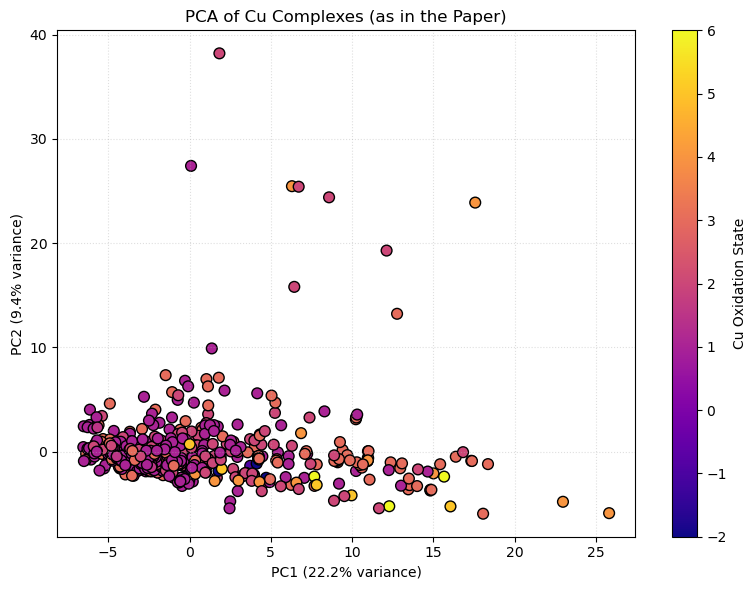

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Scale features for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Fit PCA (2 components for 2D plot)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_scaled)

# Plot, color by oxidation state
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=ox_states, cmap='plasma', s=60, edgecolor='k')
plt.colorbar(scatter, label='Cu Oxidation State')
plt.title("PCA of Cu Complexes (as in the Paper)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.grid(True, linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()